# CPA tutorial

In [1]:
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

import os
os.chdir('./../../..')
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=150)

### Download data from Google Drive and setup

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1b7gAD5Al4xxTMq4XWNIMoiLhc_YEgqu_'
output = 'docs/tutorials/notebooks/GSM_new.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1b7gAD5Al4xxTMq4XWNIMoiLhc_YEgqu_
To: /home/aletl/Documents/cpa/docs/tutorials/notebooks/GSM_new.h5ad
100%|████████████████████████████████████████| 179M/179M [00:04<00:00, 36.6MB/s]


'docs/tutorials/notebooks/GSM_new.h5ad'

In [7]:
adata = sc.read(output)
adata

AnnData object with n_obs × n_vars = 14811 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
cpa.CPA.setup_anndata(adata, 
                      drug_key='condition', 
                      dose_key='dose_val',
                      control_key='control',
                      categorical_covariate_keys=['cell_type']
                     )

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/home/aletl/anaconda3/envs/kge/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 14811 cells, 4999 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


100%|██████████████████████████████████| 14811/14811 [00:00<00:00, 53490.92it/s]


CPA takes the data from .X, where the raw counts are stored. The keys are the ones indicated in the setup_anndata function.
1. **Condition stores** the drug key.
2. **Dose_val** stores the dose receive of the indicated drug.
3. **Control**  indicates which cells are controls (1) and which cells aren't (0).
4. **Cell_type** is the only covariate in this dataset.

Also, the data has already been splitted in train, test and out-of-distribution.

In [9]:
adata.obs['split'].unique()

['test', 'ood', 'train']
Categories (3, object): ['ood', 'test', 'train']

### Train a model

To train a model, you can specify the parameters for both the model and the training in two different dictionaries. If parameters are not specified, default values are selected.

`ae_hparams` are technical parameters of the architecture of the autoencoder.

In [61]:
ae_hparams = {'autoencoder_depth': 4,
              'autoencoder_width': 512,
              'adversary_depth': 3,
              'adversary_width': 256,
              'dosers_depth': 3,
              'dosers_width': 64,
              'use_batch_norm': True,
              'use_layer_norm': False,
              'output_activation': 'linear',
              'dropout_rate': 0.0,
              'variational': False,
              'seed': 60,
              }

`trainer_params` contains the parameters related to training.

In [62]:
trainer_params = {
    'n_epochs_warmup': 0,
    'adversary_lr': 0.0006158304832265454,
    'adversary_wd': 3.546249921082396e-06,
    'adversary_steps': 5,
    'autoencoder_lr': 0.002563090275772759,
    'autoencoder_wd': 2.8299682410882683e-05,
    'dosers_lr': 0.0028643381083830787,
    'dosers_wd': 7.850495446598981e-07,
    'penalty_adversary': 6.20968938643343,
    'reg_adversary': 1.323092865499999,
    'kl_weight': 0.00000,
    'step_size_lr': 45,
}

The model is defined with the `ae_params` dictionary. It also allows to specifiy different hyperparameters such as the dimensionality of the latent space, the loss function or the doser type function.

In [12]:
model = cpa.CPA(adata=adata, 
                n_latent=256,
                loss_ae='gauss',
                doser_type='logsigm',
                split_key='split',
                **ae_hparams,
               )

/home/aletl/Documents/cpa/cpa/_model.py:454: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
Global seed set to 60


In [14]:
model.train(max_epochs=2,
            use_gpu=False, 
            batch_size=64,
            early_stopping=True,
            plan_kwargs=trainer_params,
            early_stopping_patience=15,
            check_val_every_n_epoch=20,
            save_path='trained_models/lightning_logs/GSM_new/',
           )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type      | Params
-------------------------------------
0 | module | CPAModule | 9.7 M 
-------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.911    Total estimated model params size (MB)


Epoch 2/2: 100%|██████| 2/2 [00:10<00:00,  5.03s/it, recon=-.19, adv_loss=0.472]


### Visualize loss functions

The loss functions can be visualized calling the `plot_history` of the model.

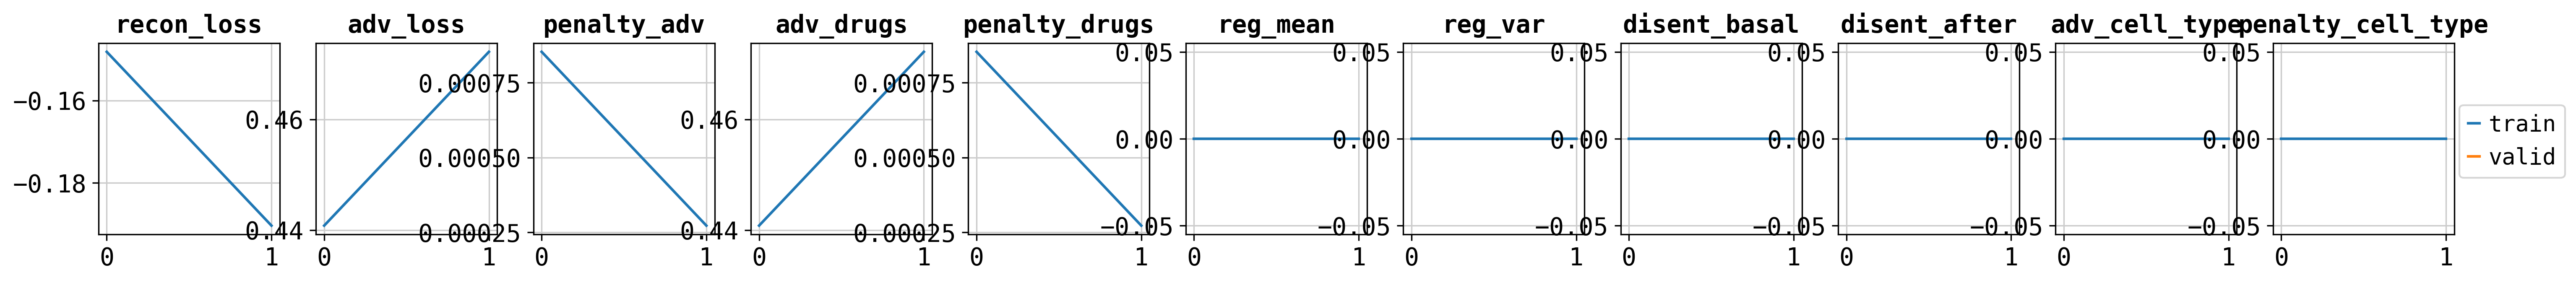

In [15]:
cpa.pl.plot_history(model)

### Working with the test data

In [16]:
test_dataset = adata[adata.obs['split'] == 'test']

In [17]:
latent_basal_adata, latent_adata = model.get_latent_representation(test_dataset, batch_size=1024)

/home/aletl/Documents/cpa/cpa/_model.py:454: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [18]:
sc.pp.neighbors(latent_basal_adata)
sc.tl.umap(latent_basal_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.
Epoch 1/1500:   0%|                                    | 0/1500 [03:11<?, ?it/s]


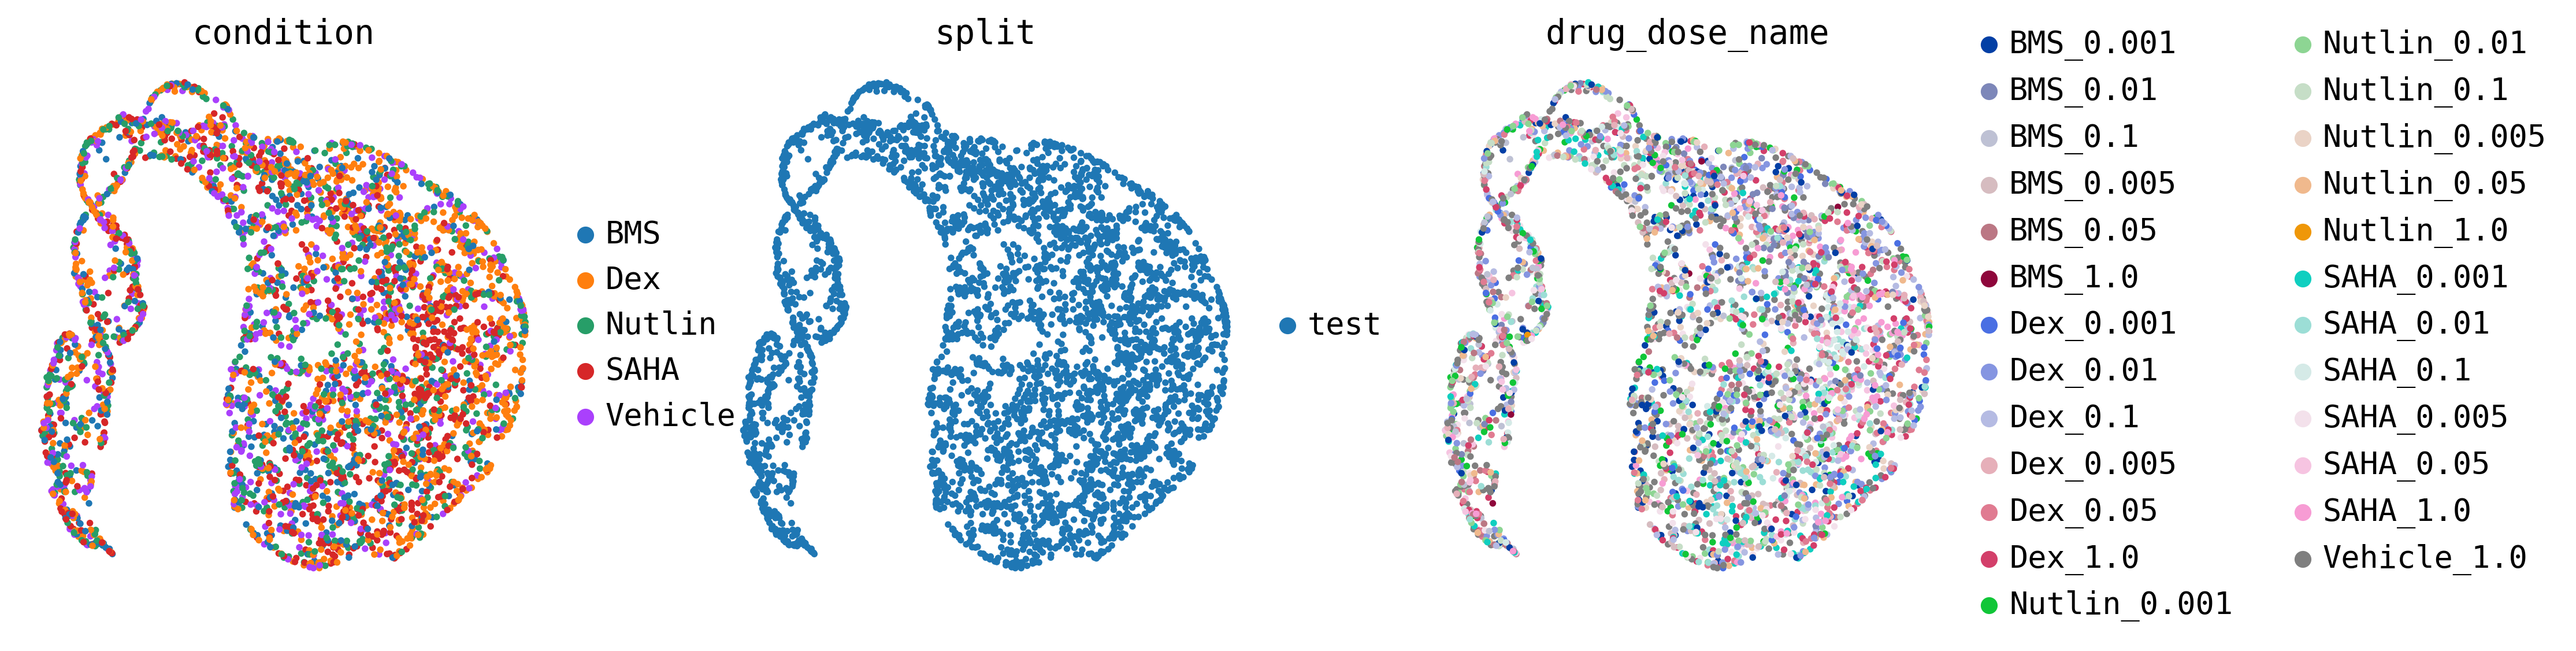

In [18]:
sc.pl.umap(latent_basal_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

In [79]:
test_dataset

View of AnnData object with n_obs × n_vars = 3914 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', '_scvi_batch', '_scvi_labels', 'cell_type_scvi'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors', '_scvi'
    obsm: 'X_pca', 'X_umap', 'drugs_doses'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [82]:
test_dataset.obs['_scvi_batch']

index
A01_A01_RT_390    0
A01_A01_RT_402    0
A01_A01_RT_434    0
A01_A01_RT_443    0
A01_A01_RT_459    0
                 ..
H12_B02_RT_708    0
H12_B02_RT_730    0
H12_B02_RT_738    0
H12_B02_RT_753    0
H12_B02_RT_761    0
Name: _scvi_batch, Length: 3914, dtype: int8

In [76]:
import torch
inference_outputs = tensors = {}
inference_outputs['latent_basal'] = torch.Tensor(latent_basal_adata.X).to(model.device)
inference_outputs['latent'] = torch.Tensor(latent_adata.X).to(model.device)
tensors['drug_name'] = torch.Tensor(test_dataset.obs['condition_scvi'].values).to(model.device)

KeyError: 'condition_scvi'

### ComPert API for compatibility with scanpy

This module allow us to plot different embeddings to gain insights about the data we are working with.

In [19]:
cpa_analyzer = cpa.ComPertAPI(adata, model)

In [20]:
perts_anndata = cpa_analyzer.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 5 × 256
    obs: 'condition'

In [21]:
covars_anndata = cpa_analyzer.get_covars_embeddings('cell_type')
covars_anndata

AnnData object with n_obs × n_vars = 1 × 256
    obs: 'cell_type'

In [22]:
drug_adata = cpa_analyzer.get_drug_embeddings()
drug_adata.shape

(5, 256)

In [23]:
cpa_analyzer.num_measured_points['train']

{'A549_BMS_0.001': 442,
 'A549_BMS_0.005': 391,
 'A549_BMS_0.01': 262,
 'A549_BMS_0.05': 134,
 'A549_BMS_0.1': 103,
 'A549_BMS_1.0': 13,
 'A549_Dex_0.001': 204,
 'A549_Dex_0.005': 264,
 'A549_Dex_0.01': 479,
 'A549_Dex_0.05': 484,
 'A549_Dex_0.1': 486,
 'A549_Dex_1.0': 568,
 'A549_Nutlin_0.001': 284,
 'A549_Nutlin_0.005': 252,
 'A549_Nutlin_0.01': 387,
 'A549_Nutlin_0.05': 350,
 'A549_Nutlin_0.1': 457,
 'A549_Nutlin_1.0': 6,
 'A549_SAHA_0.001': 392,
 'A549_SAHA_0.005': 376,
 'A549_SAHA_0.01': 383,
 'A549_SAHA_0.05': 299,
 'A549_SAHA_0.1': 297,
 'A549_SAHA_1.0': 282,
 'A549_Vehicle_1.0': 1535}

In [24]:
cpa_analyzer.compute_comb_emb(thrh=0)
cpa_analyzer.compute_uncertainty(
                    covs='A549', 
                    pert='Nutlin', 
                    dose='1.0'
                )

(0.84276545, 15.465564, 'A549_Nutlin_1.0', 'A549_Nutlin_1.0')

In [25]:
cpa_analyzer.measured_points['train']

{'A549': {'BMS': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Dex': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Nutlin': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'SAHA': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Vehicle': [1.0]}}

There exists also a module that allows to visualize the latent spaces generated by the CPA model.

In [26]:
cpa_plots = cpa.pl.CompertVisuals(cpa_analyzer, fileprefix=None)

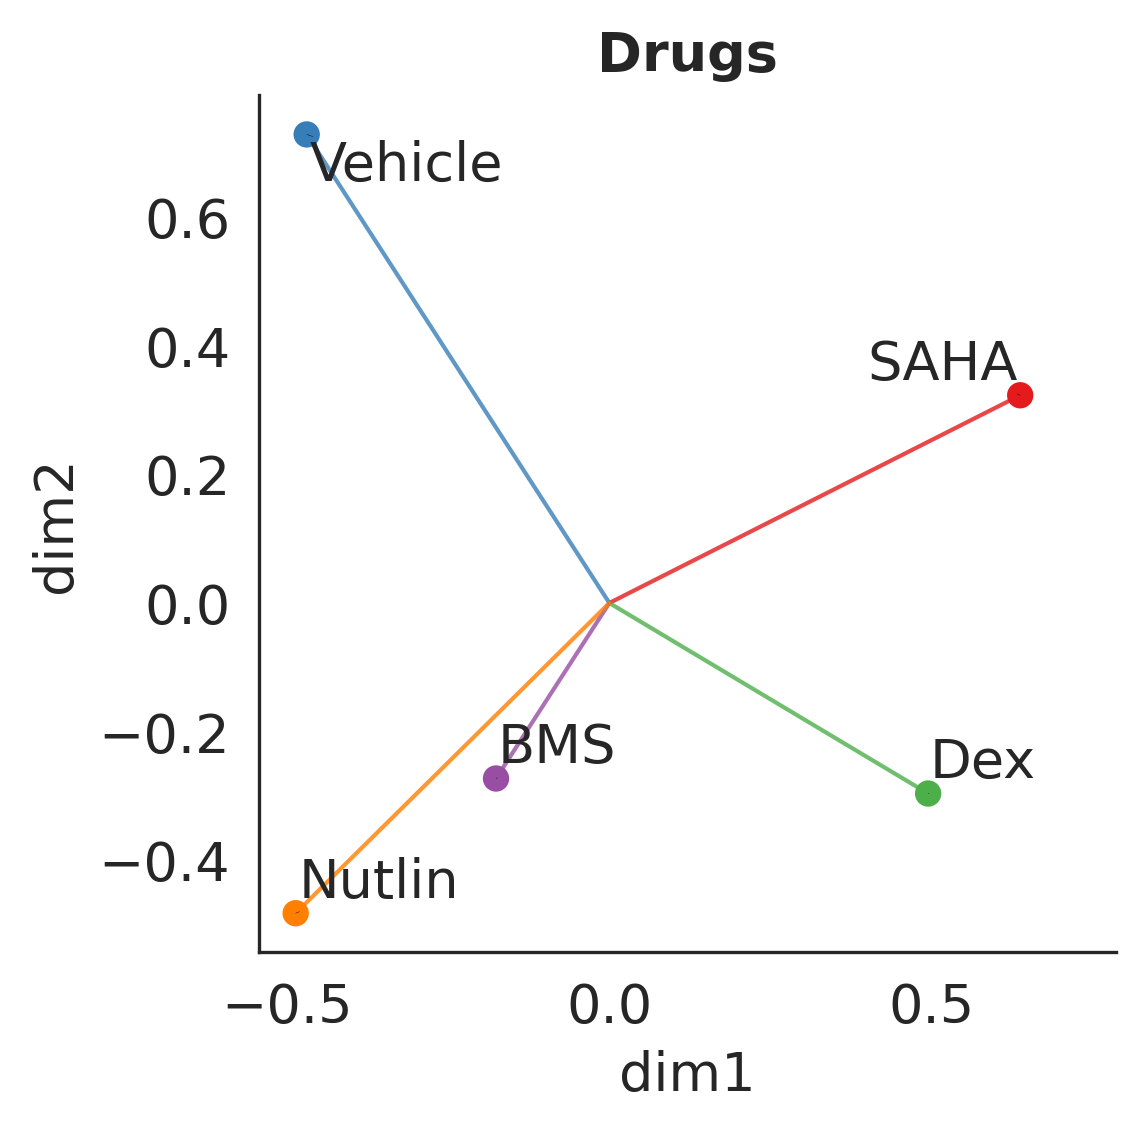

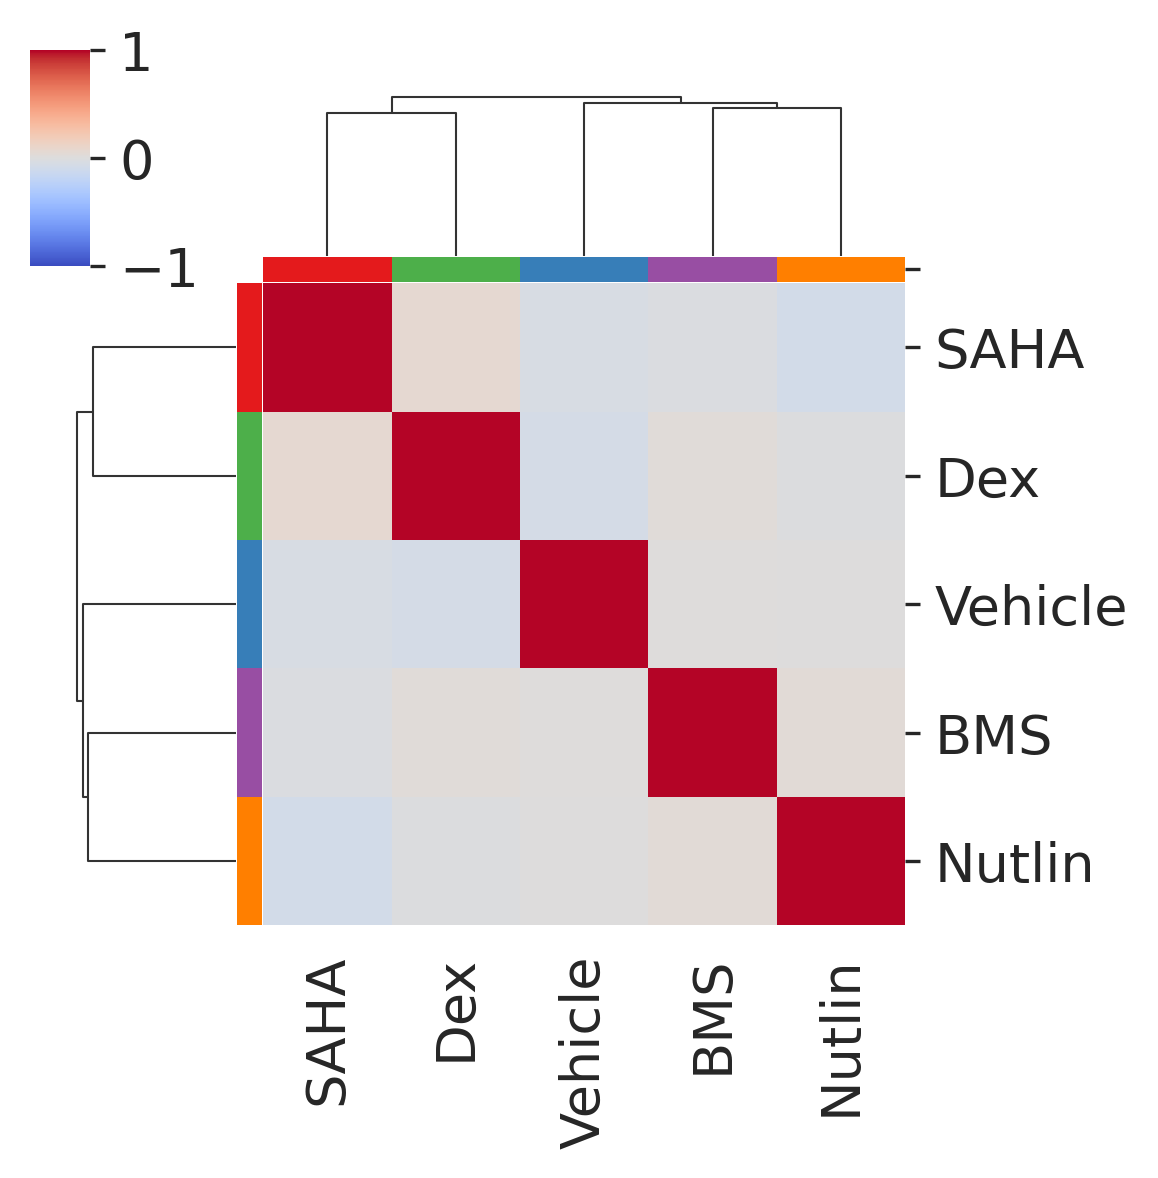

In [27]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs')

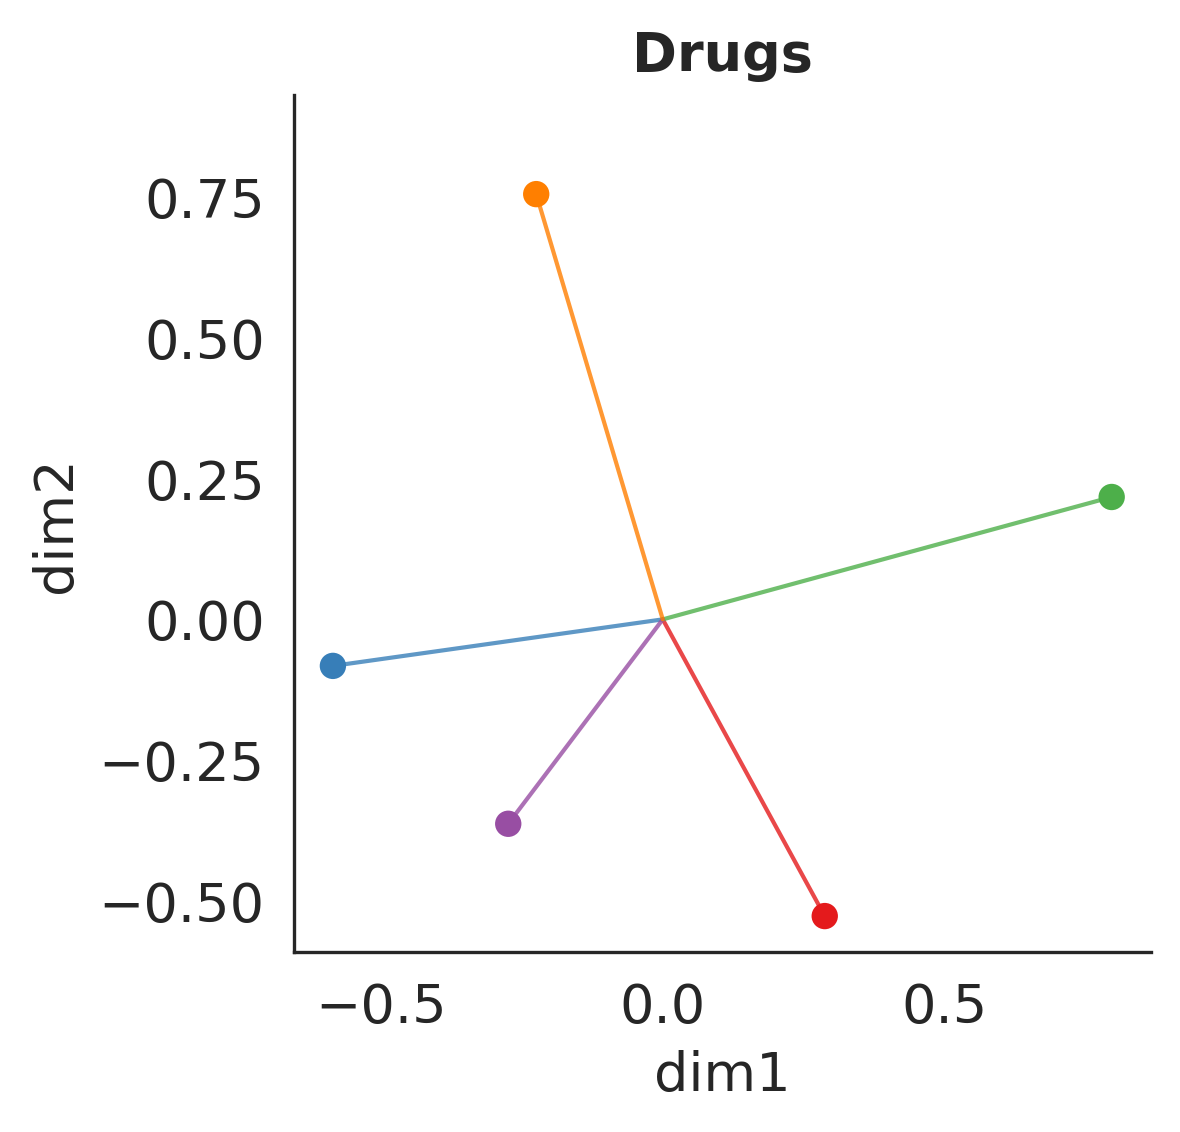

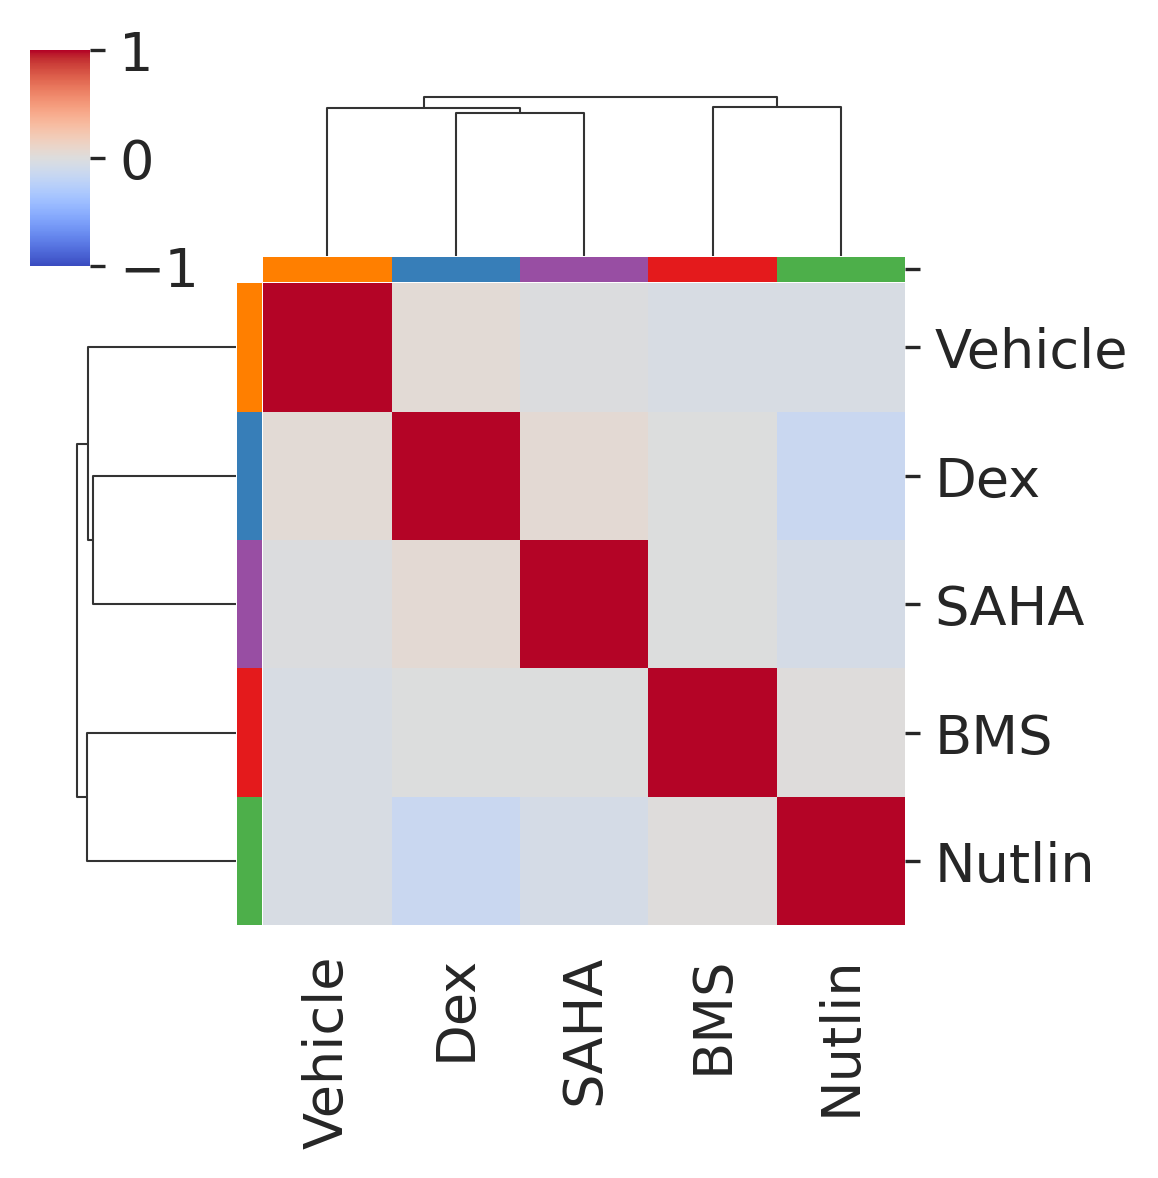

In [26]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs', show_text=False)

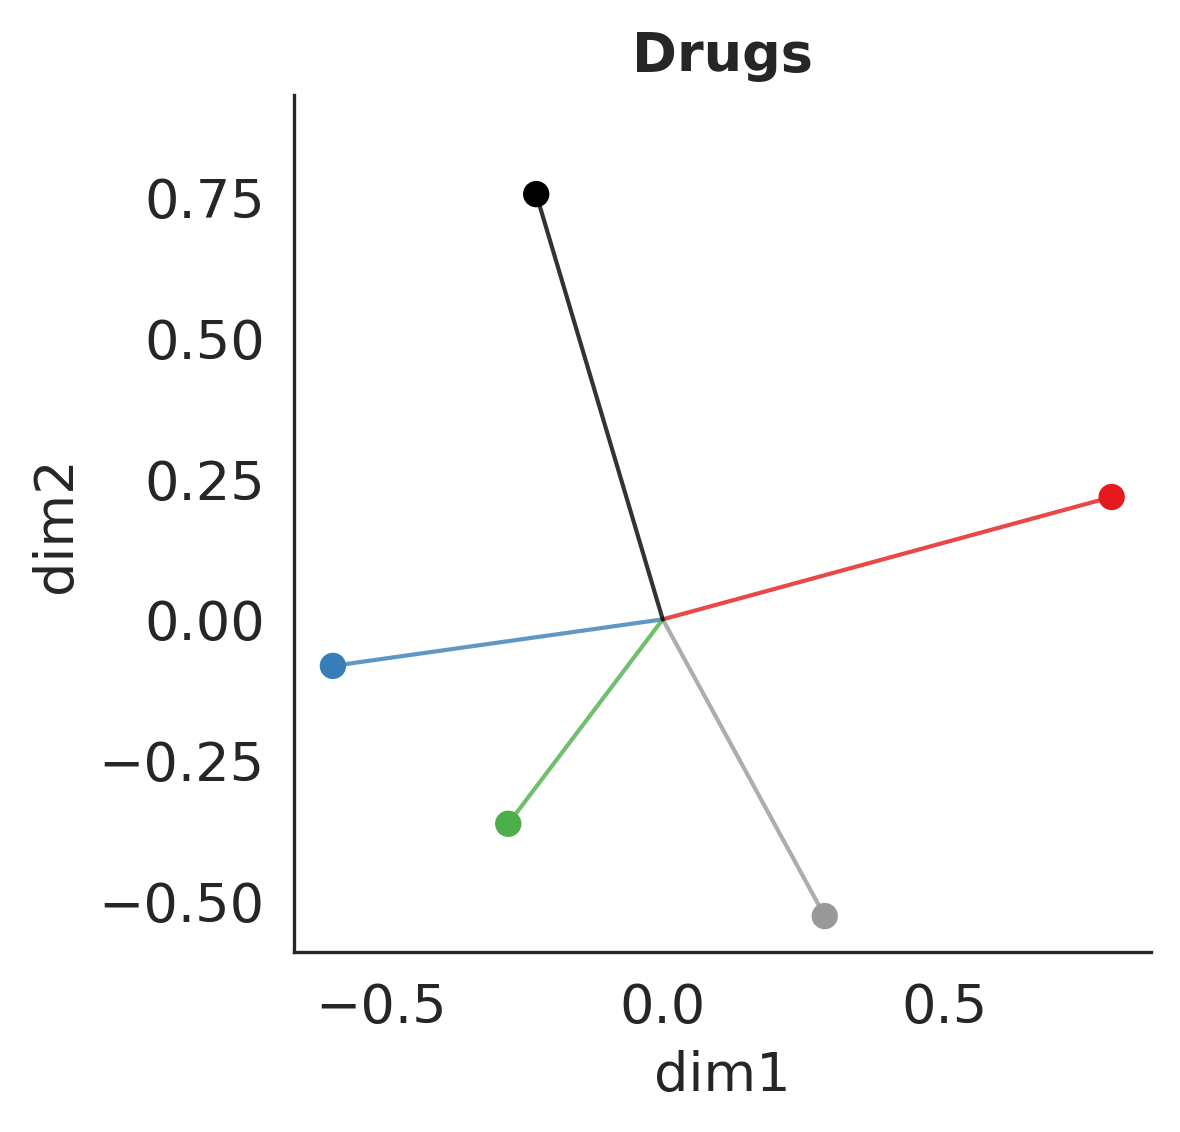

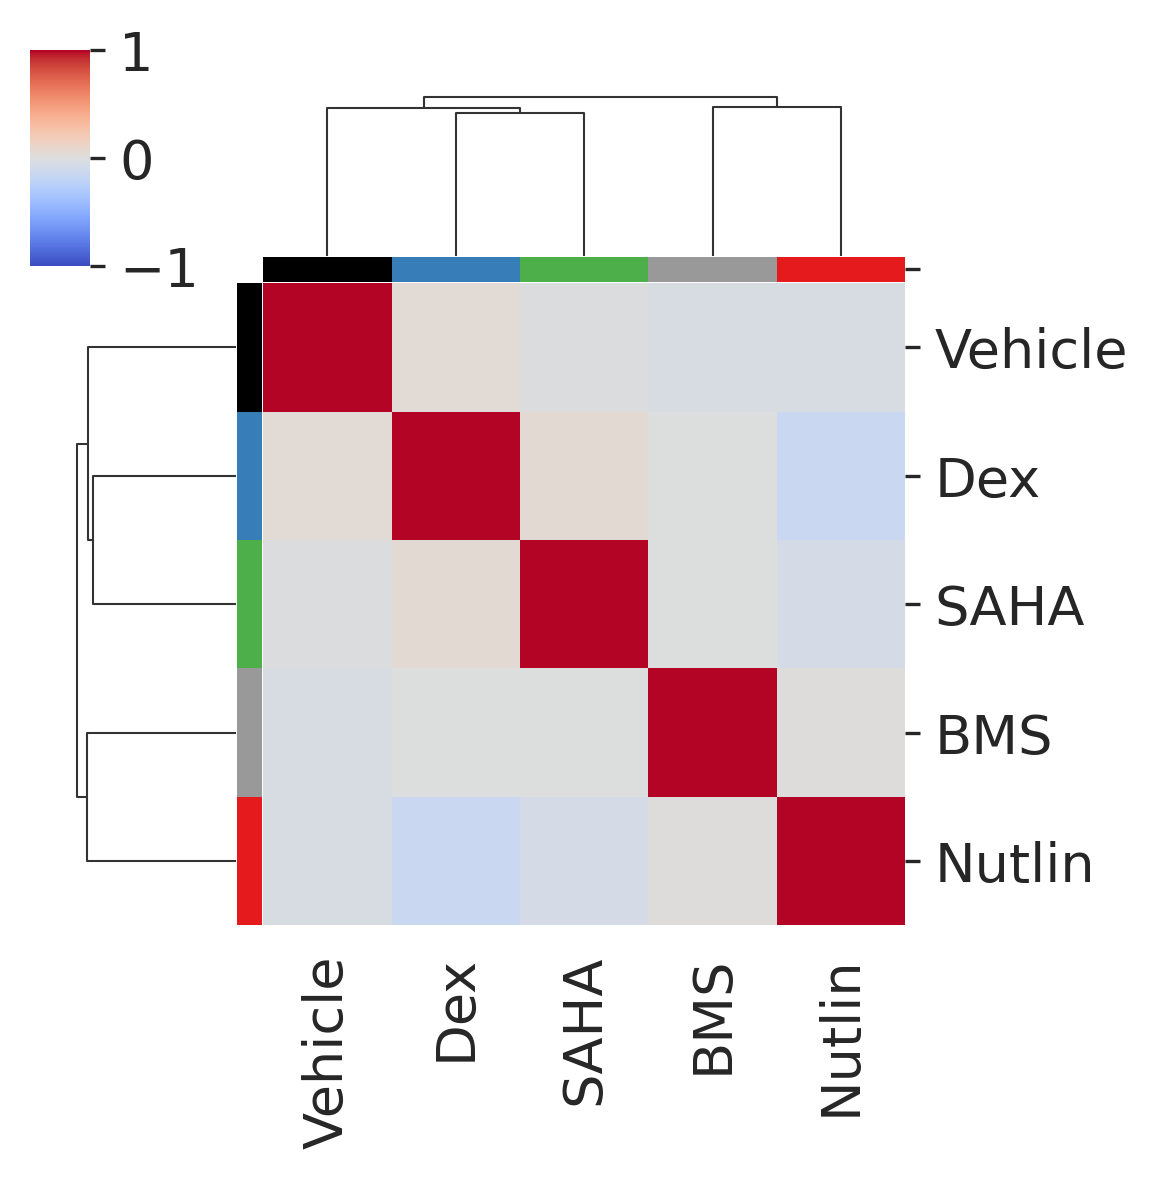

In [27]:
perts_palette = {'BMS': '#999999',                 
                 'SAHA': '#4daf4a',
                 'Dex': '#377eb8',
                 'Nutlin': '#e41a1c',
                 'Vehicle': '#000000'
    
                }

cpa_plots.perts_palette = perts_palette
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs', show_text=False)

In [28]:
cpa_plots.plot_latent_embeddings(cpa_analyzer.emb_covars, kind='cell_type')

Embedding contains only 1 vectors. Not enough to plot.


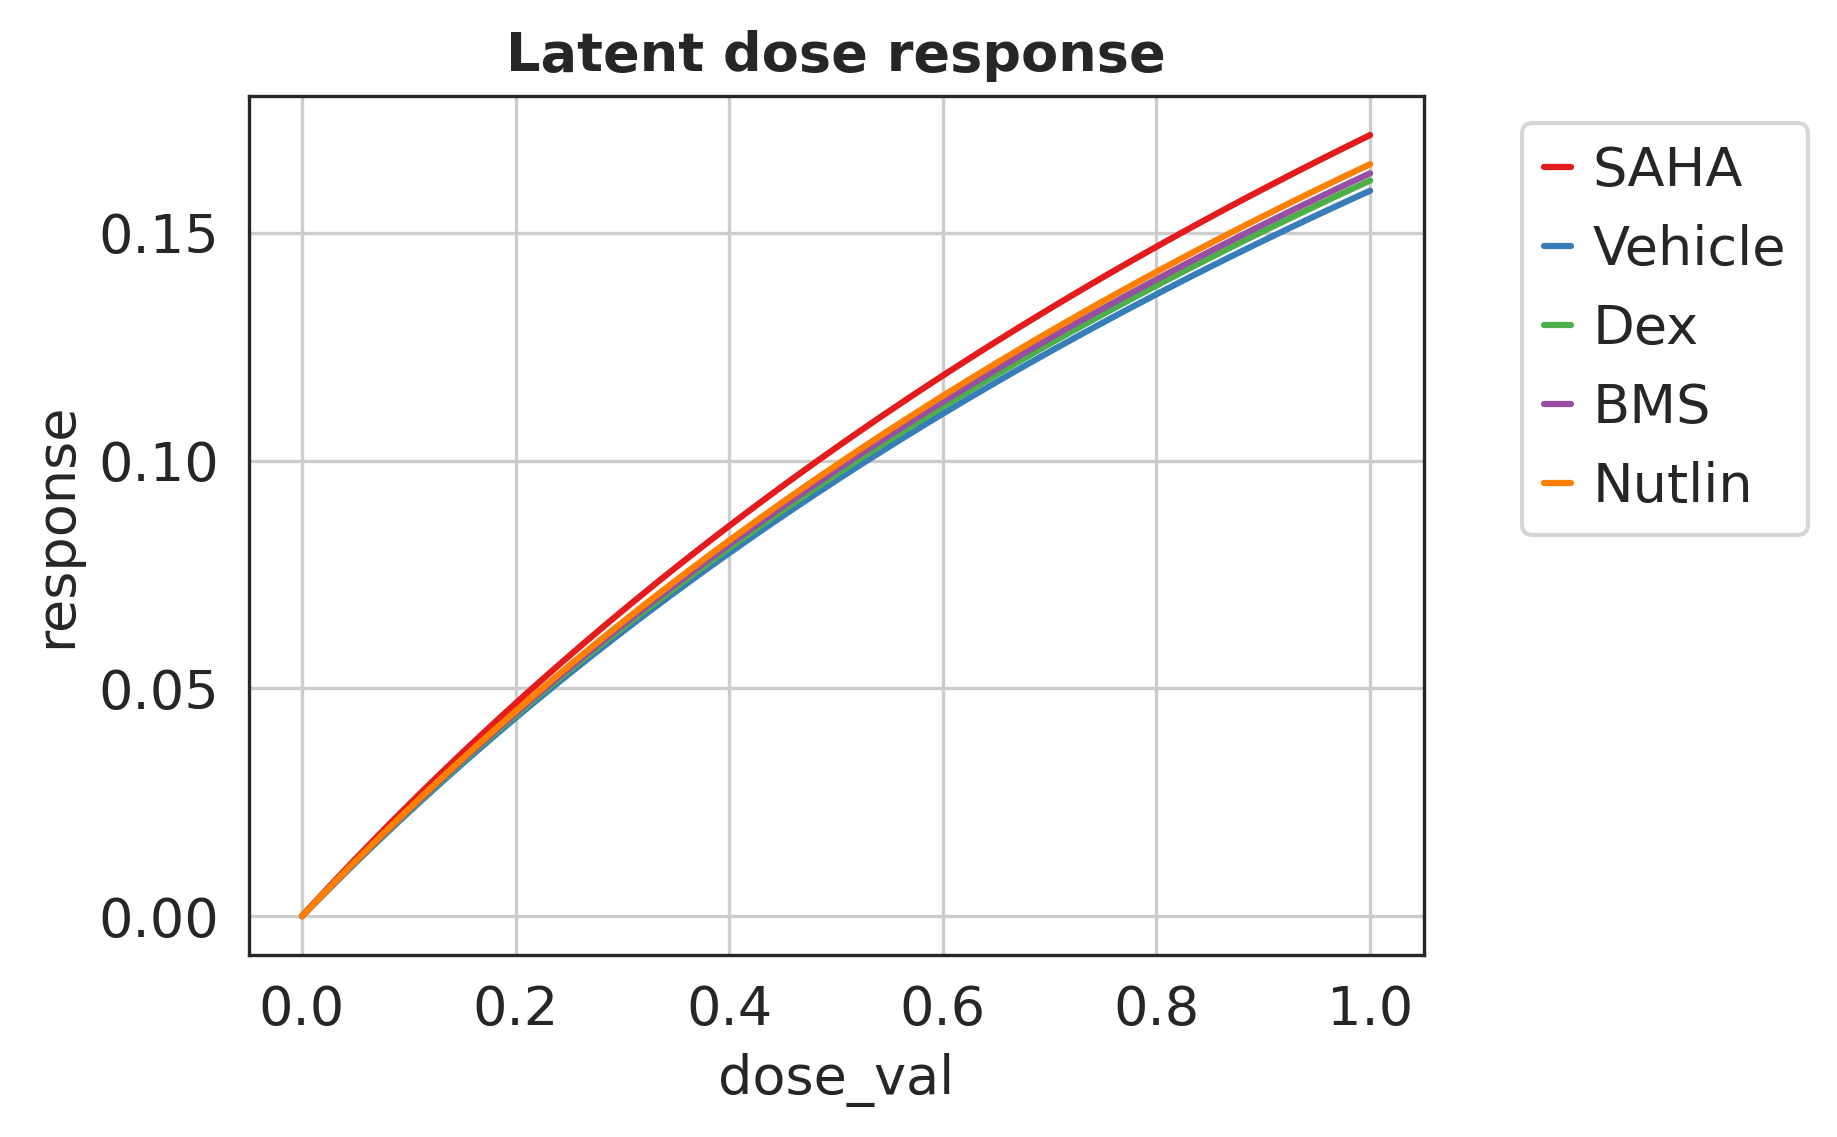

In [29]:
latent_response = cpa_analyzer.latent_dose_response(perturbations=None)
cpa_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=cpa_analyzer.perturbation_key,
    title_name='Latent dose response')

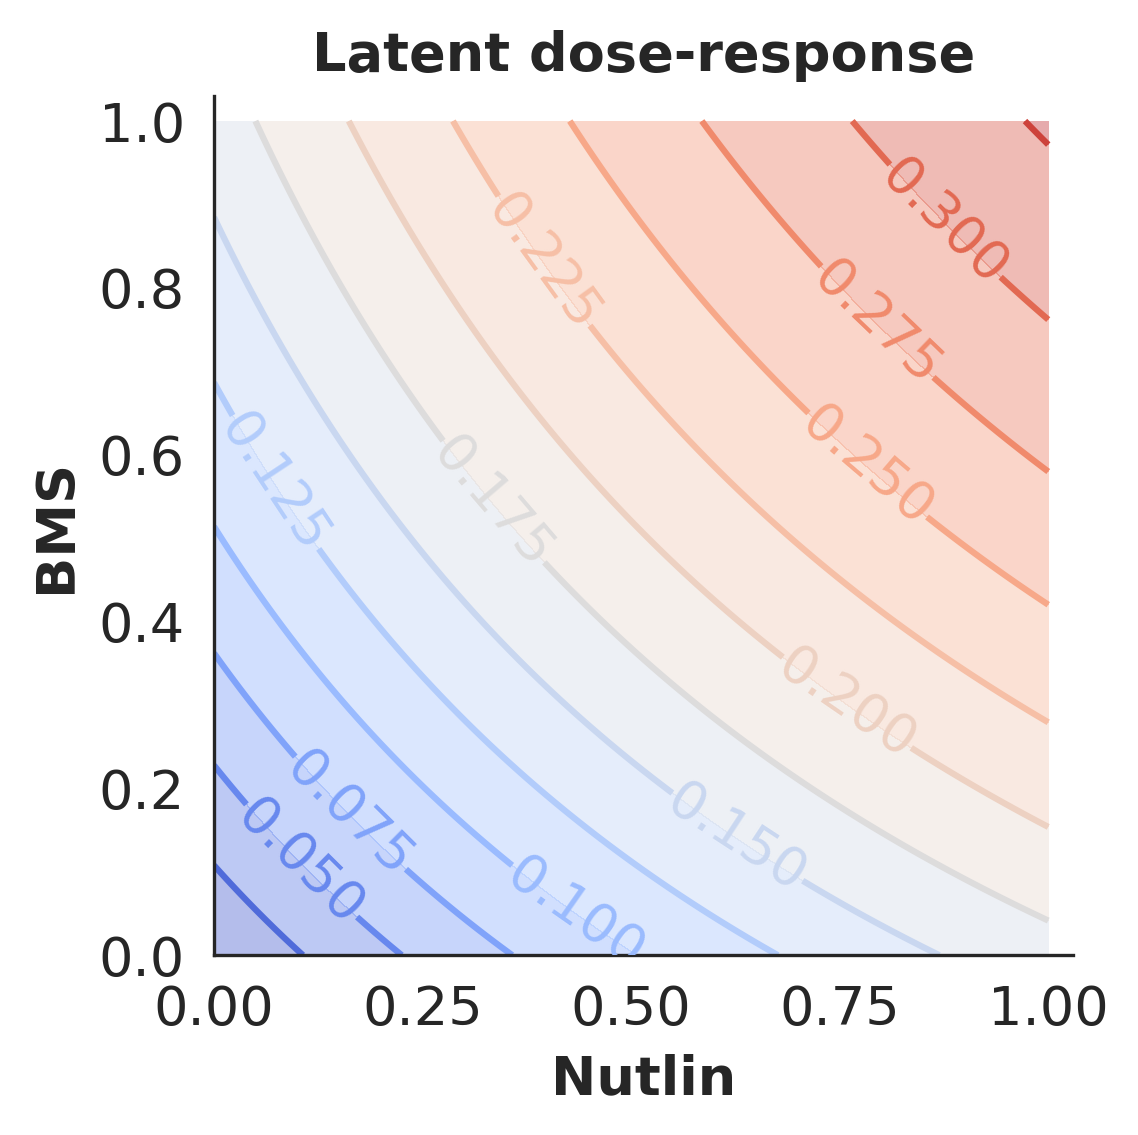

In [30]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = cpa_analyzer.latent_dose_response2D(perturbations_pair, n_points=100)
cpa_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')

In [ ]:
%%time
#reconstructed_response2D = cpa_analyzer.get_response2D(adata, perturbations_pair, cpa_analyzer.unique_covars['cell_type'])
reconstructed_response2D = cpa_analyzer.get_response2D(perturbations_pair, covar='A549', n_points=10)


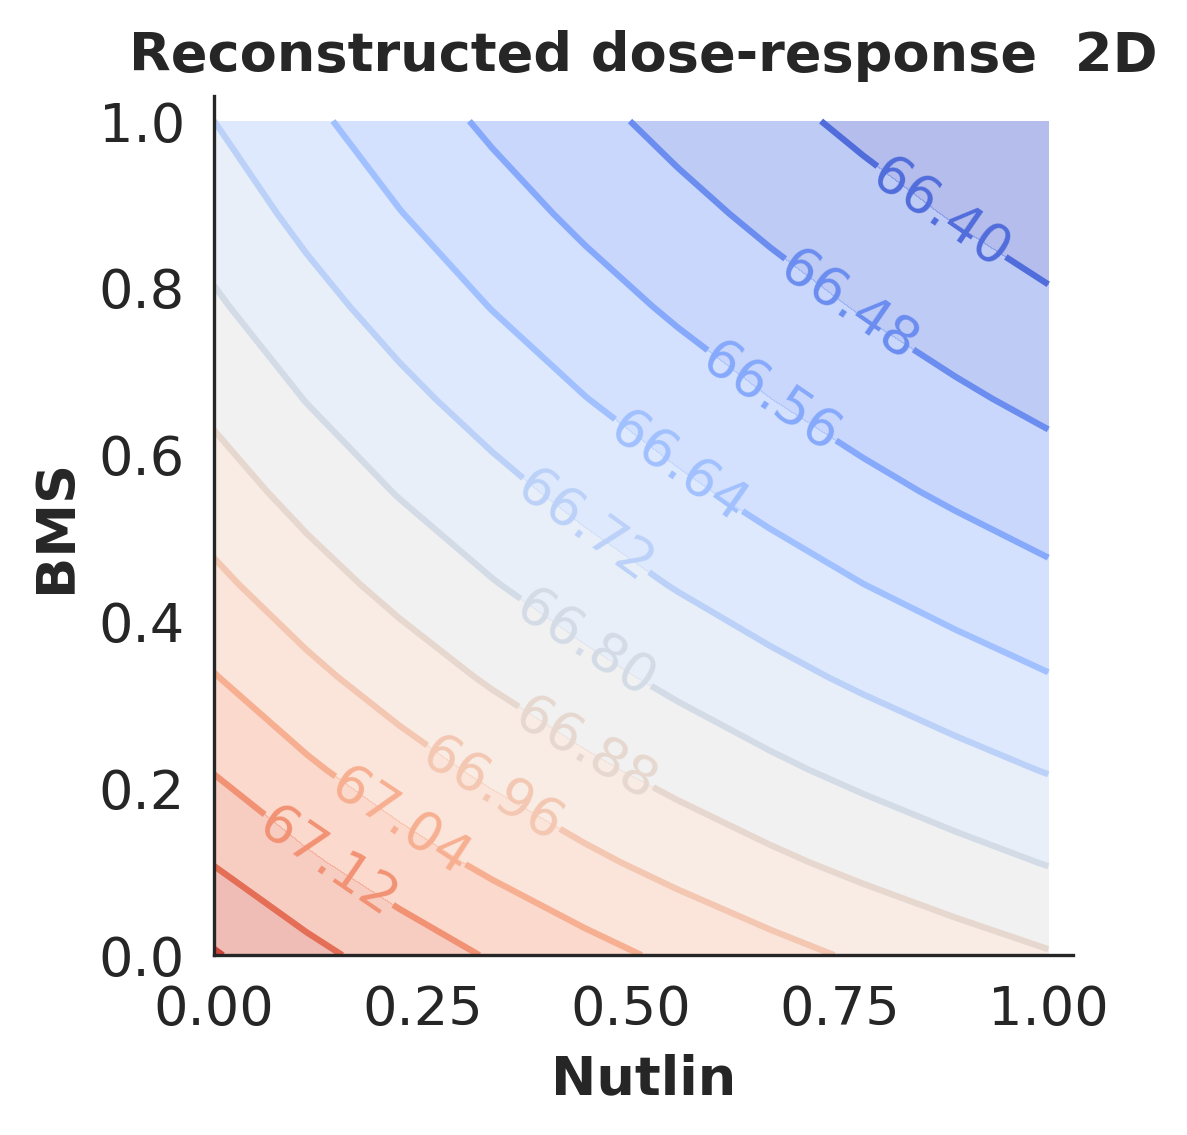

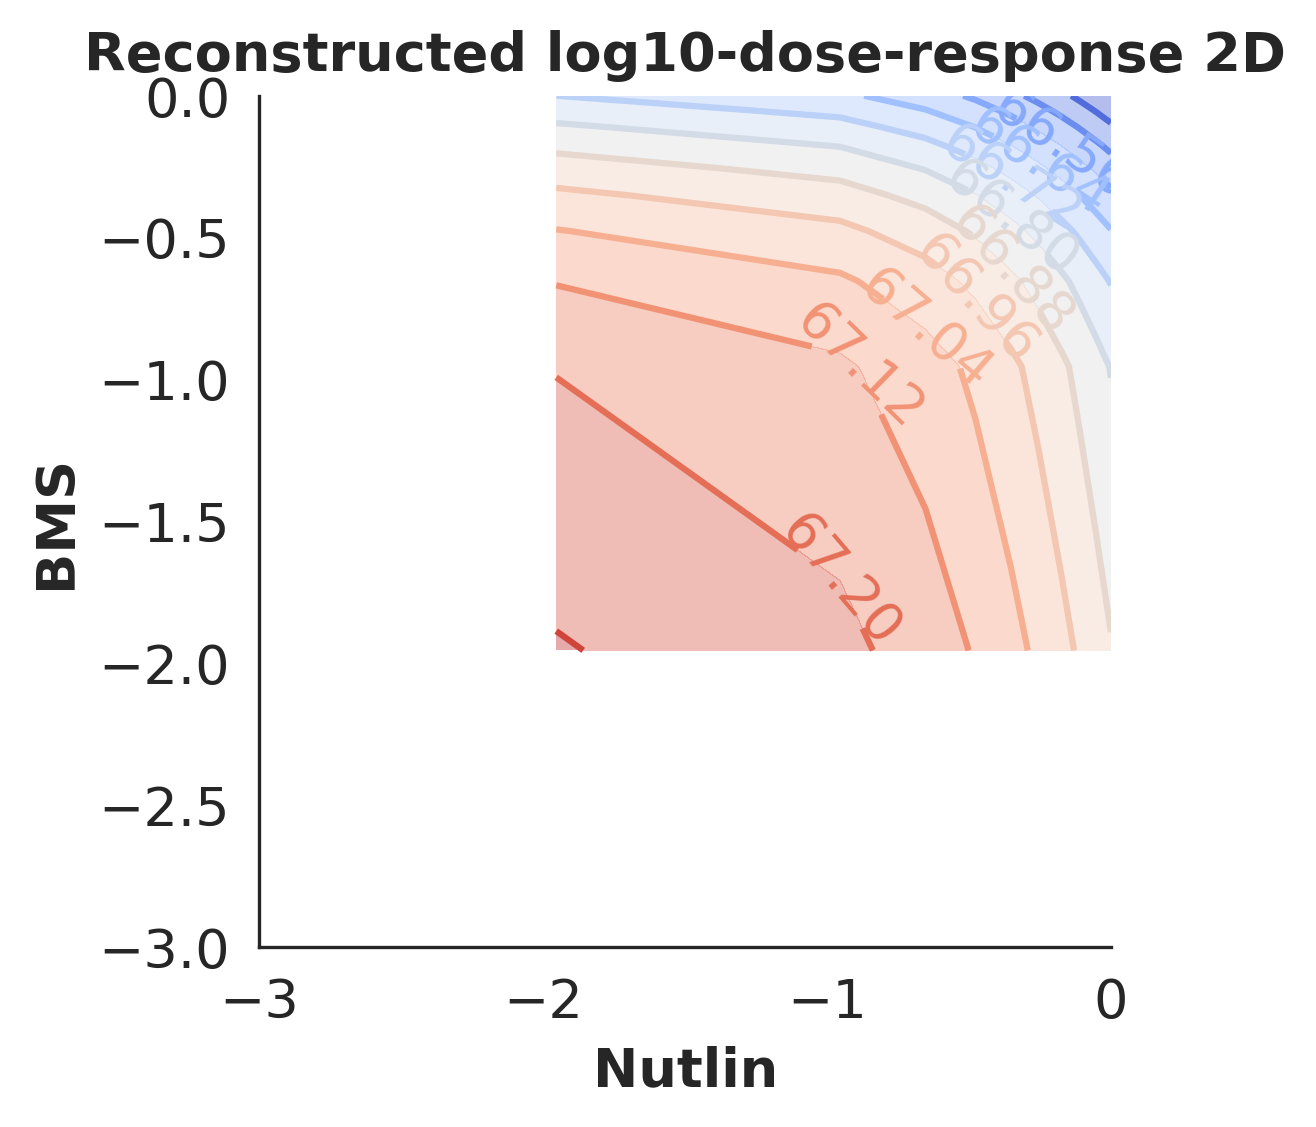

In [39]:
cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                              title_name='Reconstructed dose-response  2D',
                                              logdose=False,
                                              # xlims=(-3, 0), ylims=(-3, 0)
                                              )

cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                      title_name='Reconstructed log10-dose-response 2D',
                                      logdose=True,
                                      xlims=(-3, 0), ylims=(-3, 0)
                                      )

In [41]:
df_reference = cpa_analyzer.get_response_reference() 
df_reference

cell_type condition  dose_val             split num_cells   response  \
0       A549       BMS     0.001  training_treated       442   1.774326   
1       A549       BMS     0.005  training_treated       391   2.927792   
2       A549       BMS     0.010  training_treated       262   6.275605   
3       A549       BMS     0.050  training_treated       134   6.652686   
4       A549       BMS     0.100  training_treated       103   5.900538   
5       A549       BMS     1.000  training_treated        13   6.896039   
6       A549       Dex     0.001  training_treated       204   4.275982   
7       A549       Dex     0.005  training_treated       264   5.173785   
8       A549       Dex     0.010  training_treated       479   5.115567   
9       A549       Dex     0.050  training_treated       484   5.259131   
10      A549       Dex     0.100  training_treated       486   5.268104   
11      A549       Dex     1.000  training_treated       568   4.823842   
12      A549    Nutlin     0.001  training_treated       284   1.510333   
13      A549    Nutlin     0.005  training_treated       252   1.967429   
14      A549    Nutlin     0.010  training_treated       387   2.279955   
15      A549    Nutlin     0.050  training_treated       350   4.993850   
16      A549    Nutlin     0.100  training_treated       457   5.623224   
17      A549    Nutlin     1.000  training_treated         6   8.057699   
18      A549      SAHA     0.001  training_treated       392   3.321342   
19      A549      SAHA     0.005  training_treated       376   6.813920   
20      A549      SAHA     0.010  training_treated       383   9.039158   
21      A549      SAHA     0.050  training_treated       299  10.920268   
22      A549      SAHA     0.100  training_treated       297  11.257531   
23      A549      SAHA     1.000  training_treated       282  10.357237   
24      A549       BMS     0.500               ood        34   4.400669   
25      A549       Dex     0.500               ood       864   5.080237   
26      A549    Nutlin     0.500               ood       265   6.537680   
27      A549      SAHA     0.500               ood       604  10.565555   

       SCYL3  C1orf112      GCLC     STPG1  ...  AL589669.1  AL391117.1  \
0  -0.003192 -0.016493  0.029825 -0.008942  ...    0.002200   -0.008055   
1   0.007327 -0.006961 -0.233149 -0.004181  ...   -0.000393   -0.002095   
2  -0.034505 -0.045197 -0.214411  0.006304  ...    0.004329    0.001807   
3  -0.006467  0.111383 -0.547656  0.005964  ...   -0.004001    0.034350   
4  -0.041323 -0.026907 -0.458251 -0.010185  ...   -0.004001    0.004597   
5  -0.017251 -0.106872 -0.444323 -0.044023  ...    0.123249    0.119595   
6  -0.021615 -0.043088 -0.326841 -0.011884  ...    0.001416   -0.017892   
7  -0.003152 -0.071998 -0.383360 -0.007214  ...   -0.002617   -0.007519   
8   0.001587 -0.046939 -0.365388 -0.014192  ...   -0.003403   -0.005959   
9  -0.005533 -0.054501 -0.325876 -0.003295  ...   -0.002677    0.000382   
10  0.003274 -0.072668 -0.352543 -0.009634  ...    0.000915   -0.000696   
11  0.005017 -0.059122 -0.328365  0.000793  ...   -0.001114   -0.001766   
12 -0.015868 -0.000781  0.057258 -0.006005  ...    0.003988    0.004151   
13 -0.008536 -0.024213  0.003470 -0.014202  ...   -0.004001   -0.006642   
14  0.003695 -0.025005  0.010109 -0.002495  ...    0.002365    0.000266   
15 -0.026727 -0.071413 -0.173213 -0.018737  ...    0.000241   -0.000609   
16  0.002691 -0.050754 -0.171111  0.001612  ...    0.007547    0.004394   
17 -0.063864 -0.106872 -0.508171 -0.044023  ...   -0.004001   -0.021099   
18  0.006053 -0.033286 -0.311057 -0.008062  ...   -0.004001   -0.002083   
19  0.000500 -0.039217 -0.198957  0.007447  ...   -0.001091   -0.008411   
20 -0.023825  0.077998  0.073692  0.004977  ...   -0.004001   -0.007696   
21 -0.028163  0.209599 -0.035475  0.002023  ...   -0.004001   -0.009620   
22 -0.029152  0.234854 -0.088409 -0.005015  ...   -0.001043   -0.005664   
23 -0.022715  0.072339 -0.3

In [ ]:
reconstructed_response = cpa_analyzer.get_response()

In [63]:
reconstructed_response['source'] = 'pred'
df_reference['source'] = 'true'



You can plot an average response (saved under "response" column) among all genes, however, we don't consider it to be a good metric and strongly advise to look at the individual response among DE genes.

Solid lines in this plot correspond to the model predictions, dashed lines -- linear interpolations between measured points. Dots represent measured points, their color is proportional to the number of cells in this condition. Black dots represent points used in training and red dots correspond to the out-of-distribution examples.


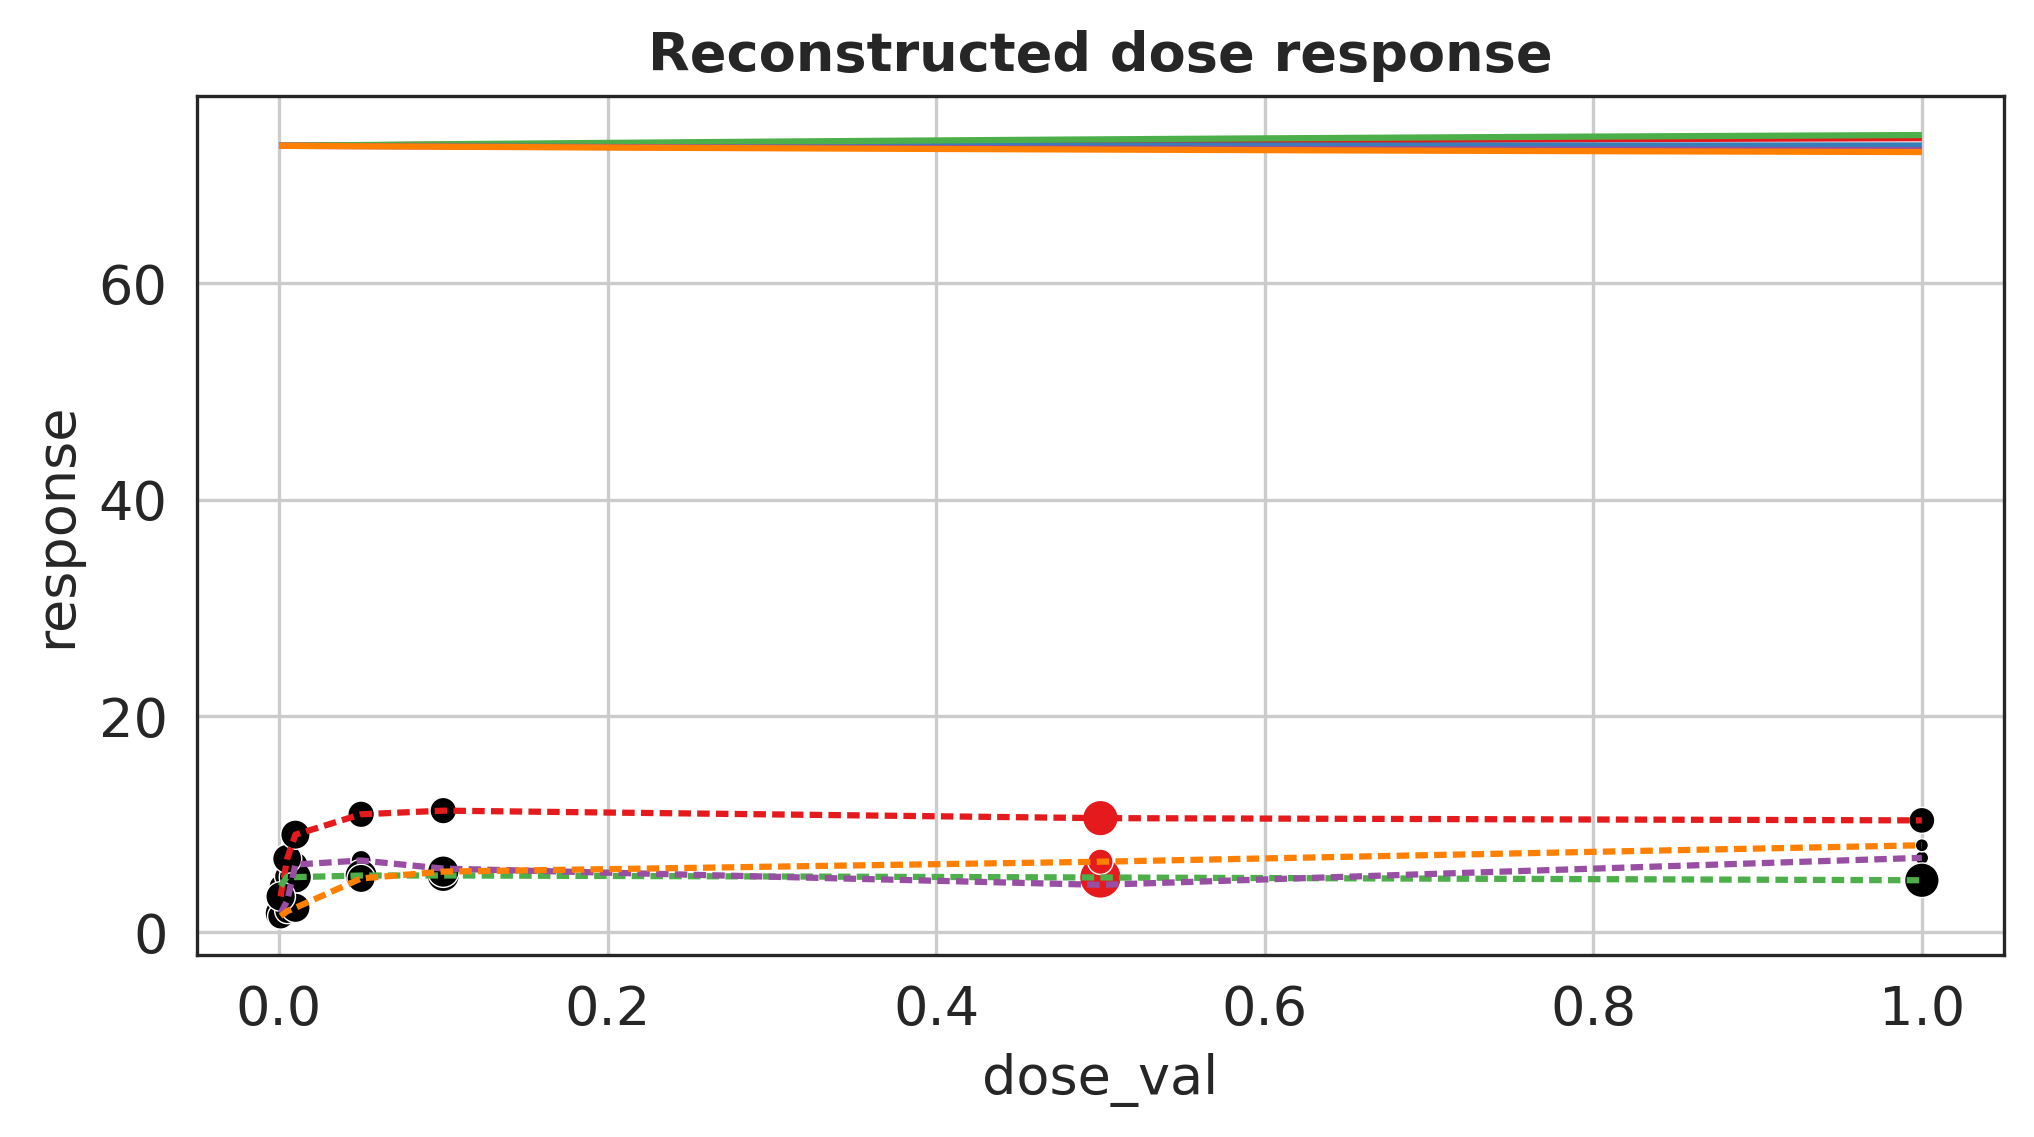

In [44]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    ref_name='source',
    title_name='Reconstructed dose response')

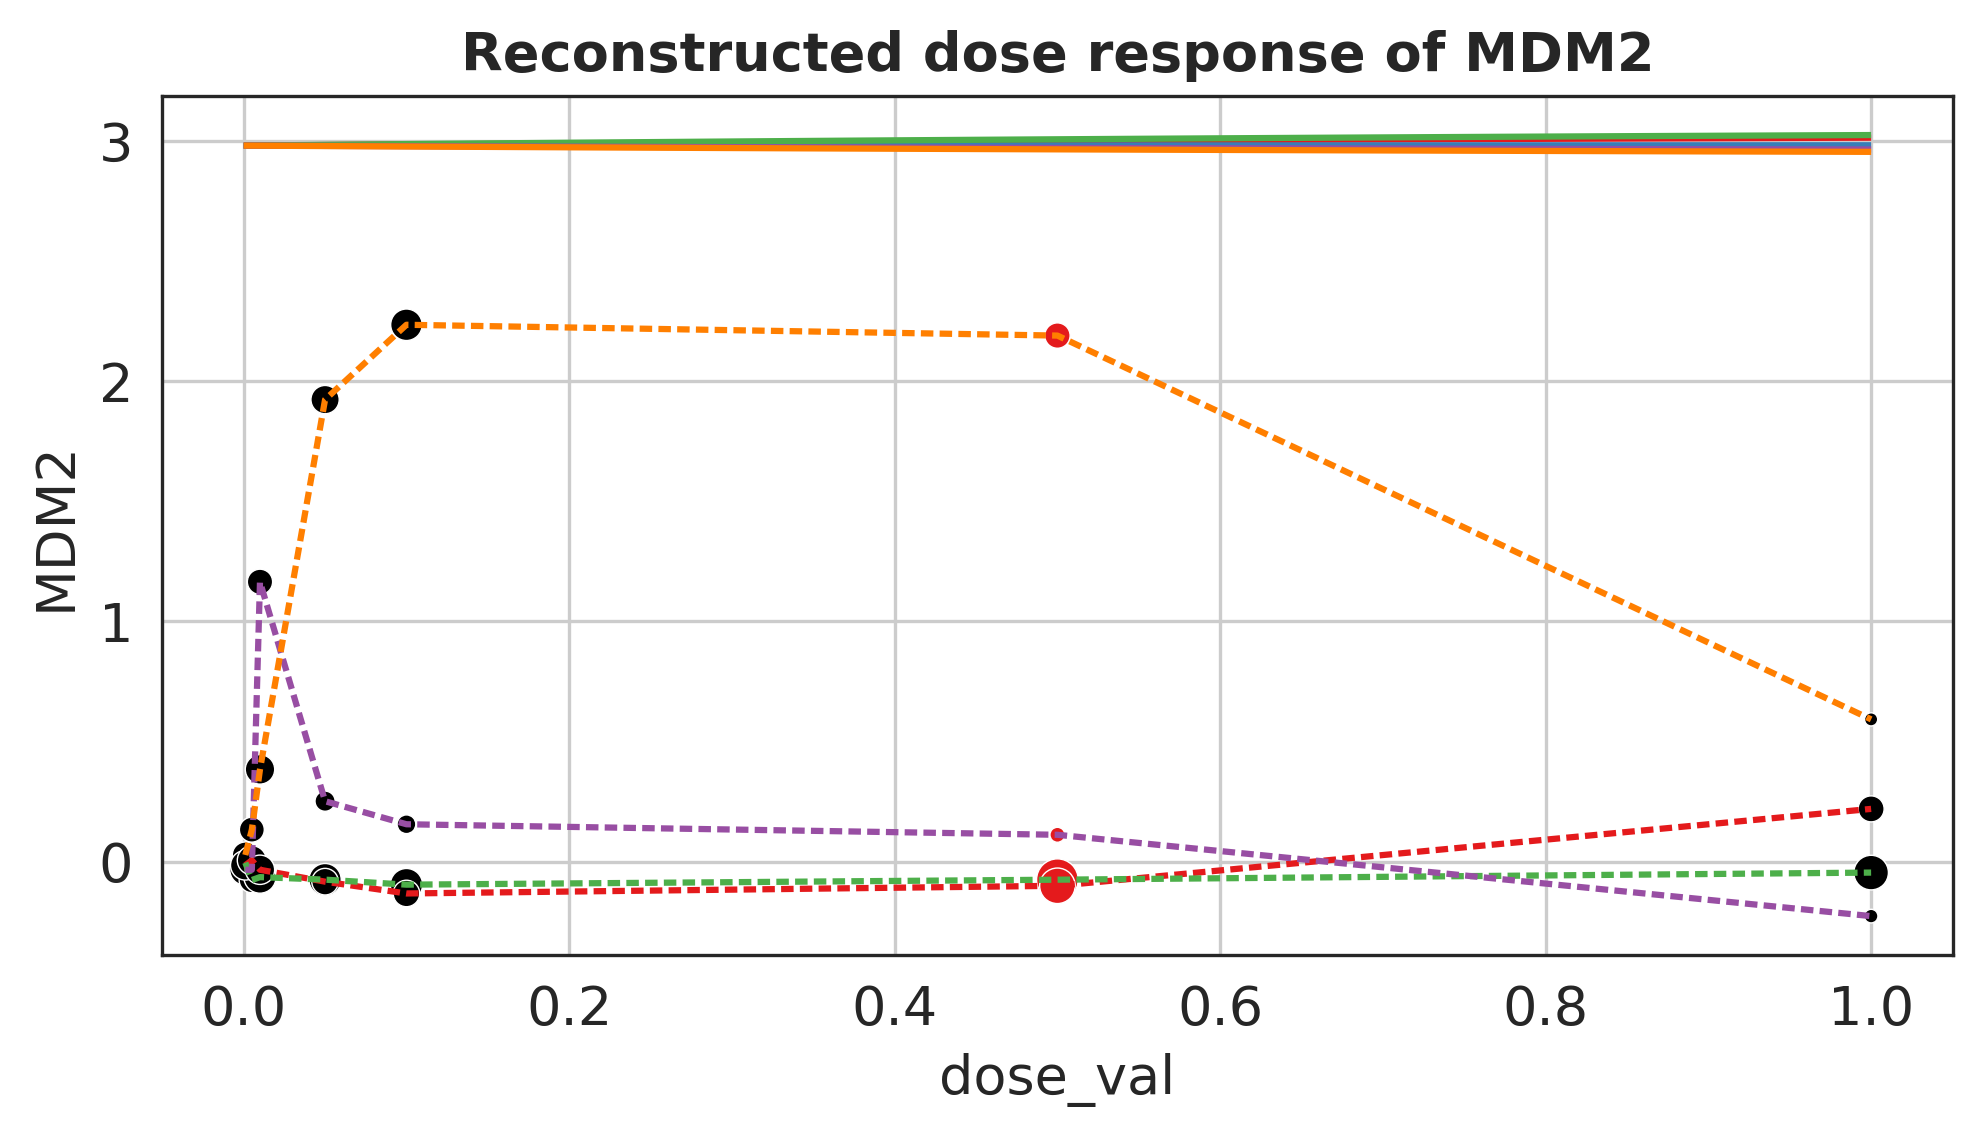

In [45]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    title_name='Reconstructed dose response of MDM2')

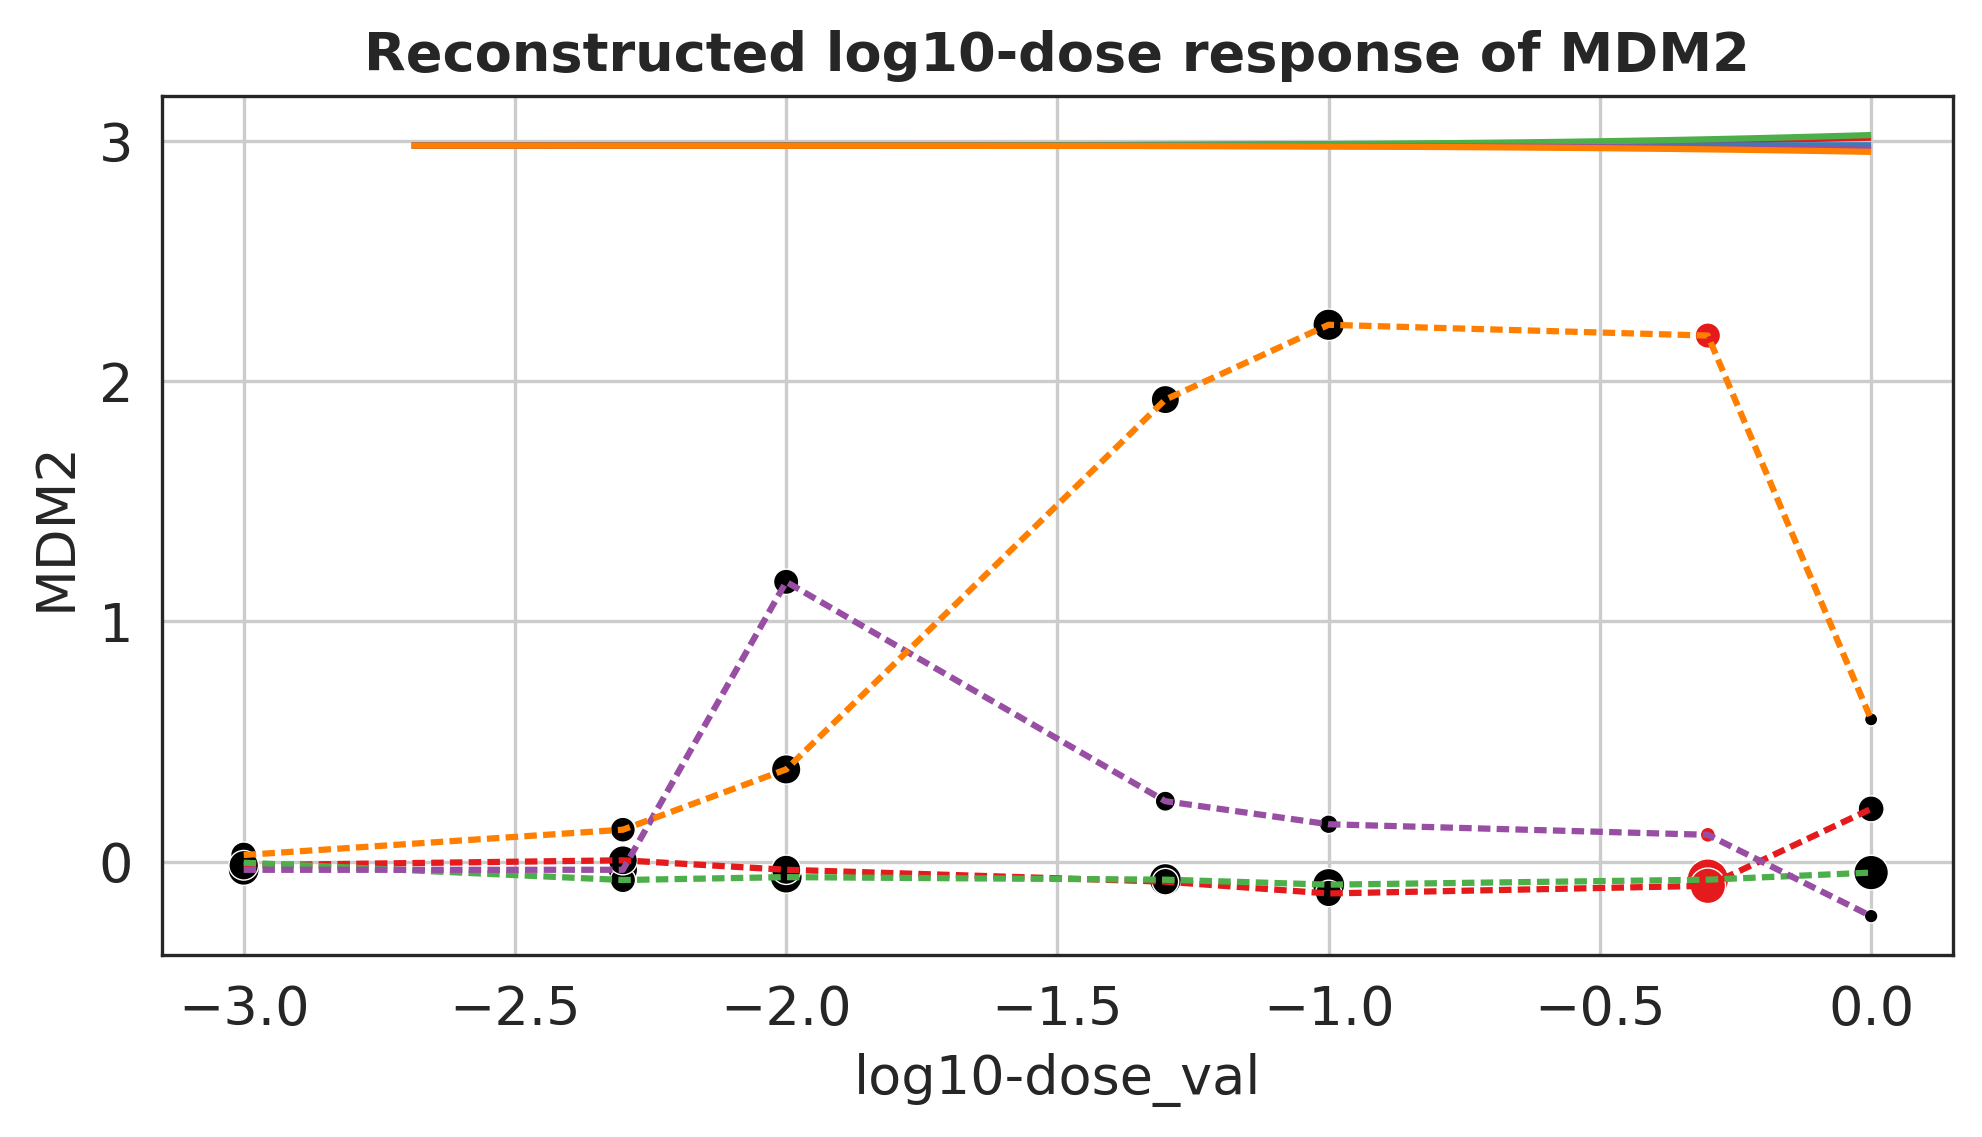

In [46]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    logdose=True,
    title_name='Reconstructed log10-dose response of MDM2')

## Predictions

In [70]:
print('Perturbations:', cpa_analyzer.unique_perts)
print('Covariates:', cpa_analyzer.unique_covars)
print('Datasets splits:', adata.obs['split'].unique())

Perturbations: ['SAHA', 'Vehicle', 'Dex', 'BMS', 'Nutlin']
Covariates: {'cell_type': ['A549']}
Datasets splits: ['test', 'ood', 'train']
Categories (3, object): ['ood', 'test', 'train']


### Uncertainty



We can profile all the predictions with an uncertainty score. Low uncertainty means "good/trustworthy" predictions, high values mean "bad/unknown quality" predictions.


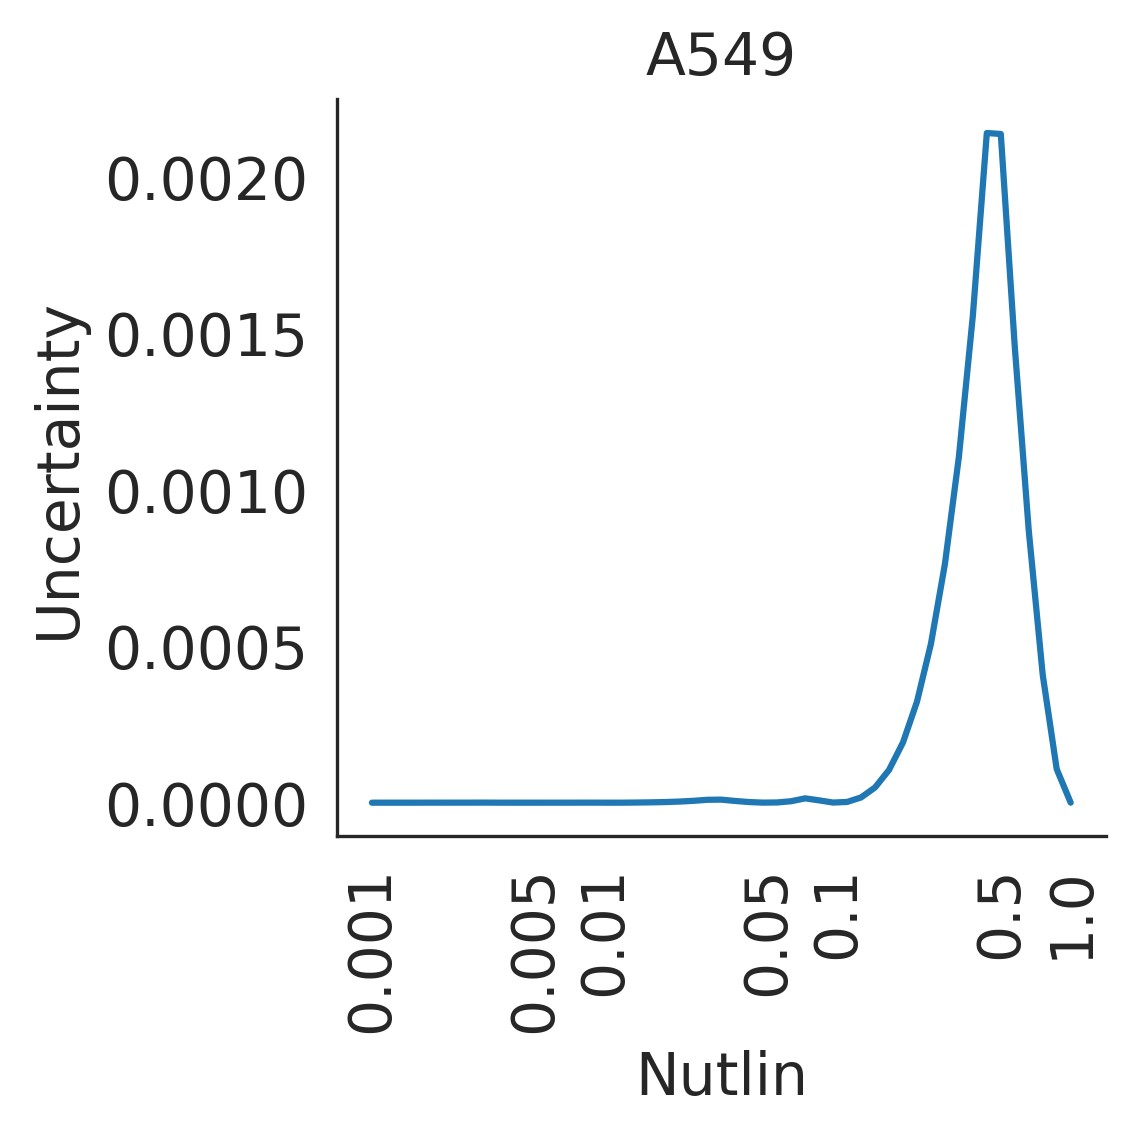

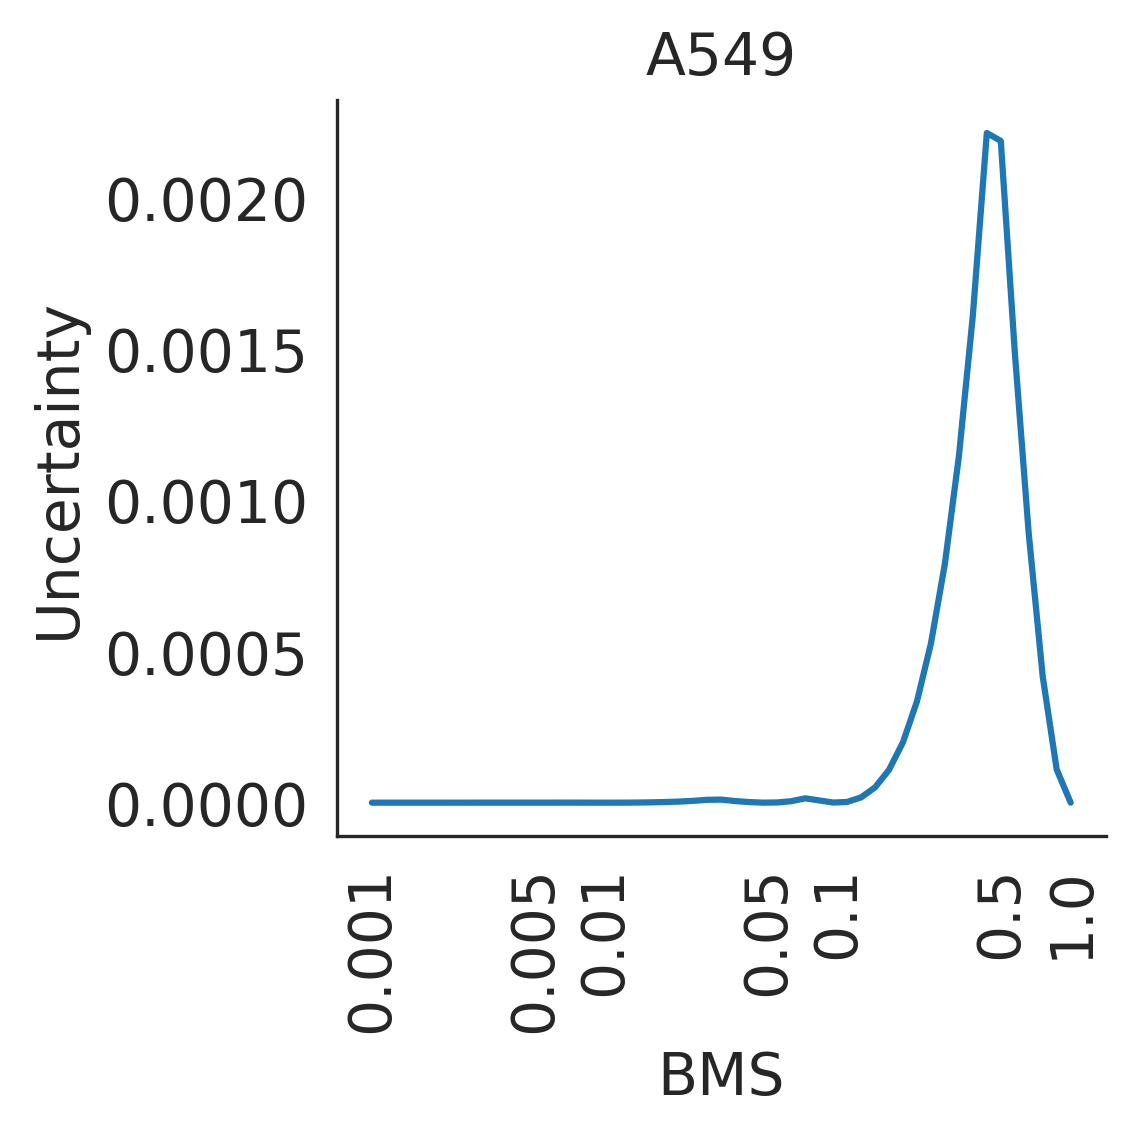

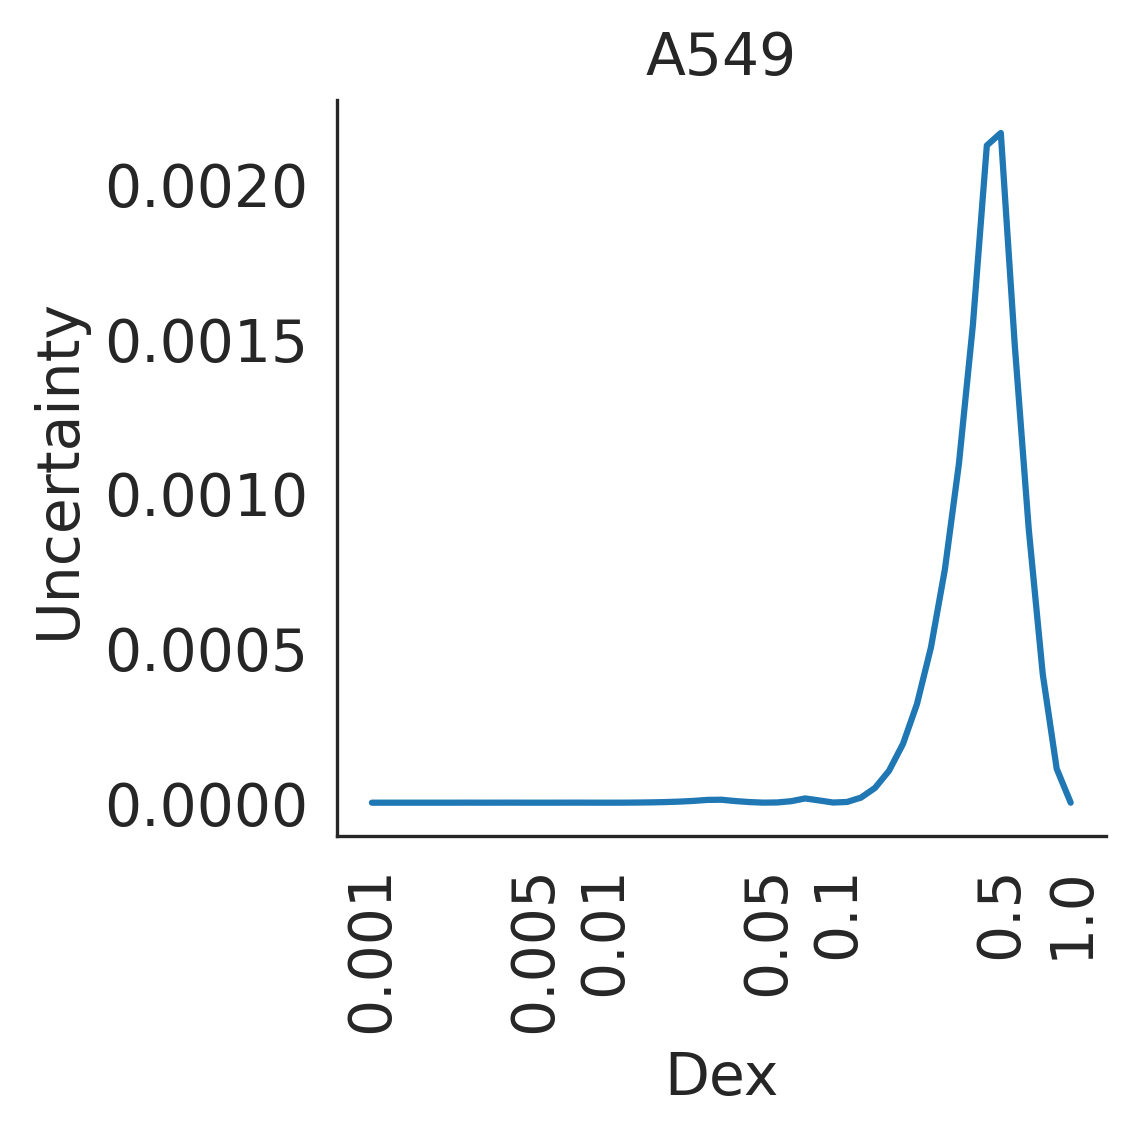

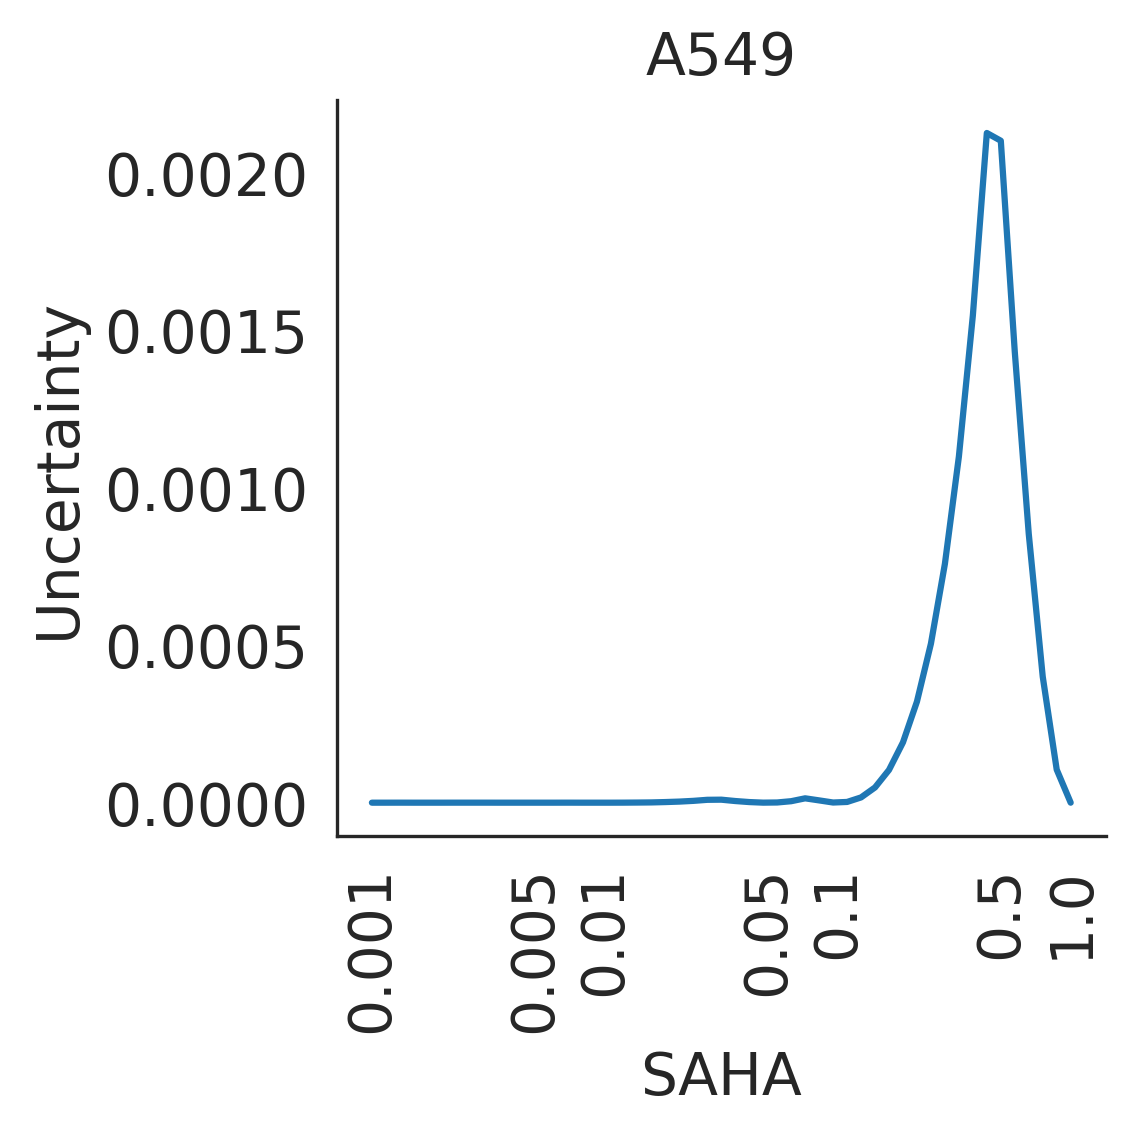

In [47]:
for drug in ['Nutlin', 'BMS', 'Dex', 'SAHA']:
    df_pred = cpa.pl.plot_uncertainty_dose(
        cpa_analyzer,
        cov='A549',
        pert=drug,
        N=51,
        measured_points=cpa_analyzer.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='cosine'
    )



Previously, we demonstrated CPA predictions for drugs combinations. But our training data didn't contain any combinations examples. How much can we trust these examples? We can try to asses by running model uncertainty predictions:


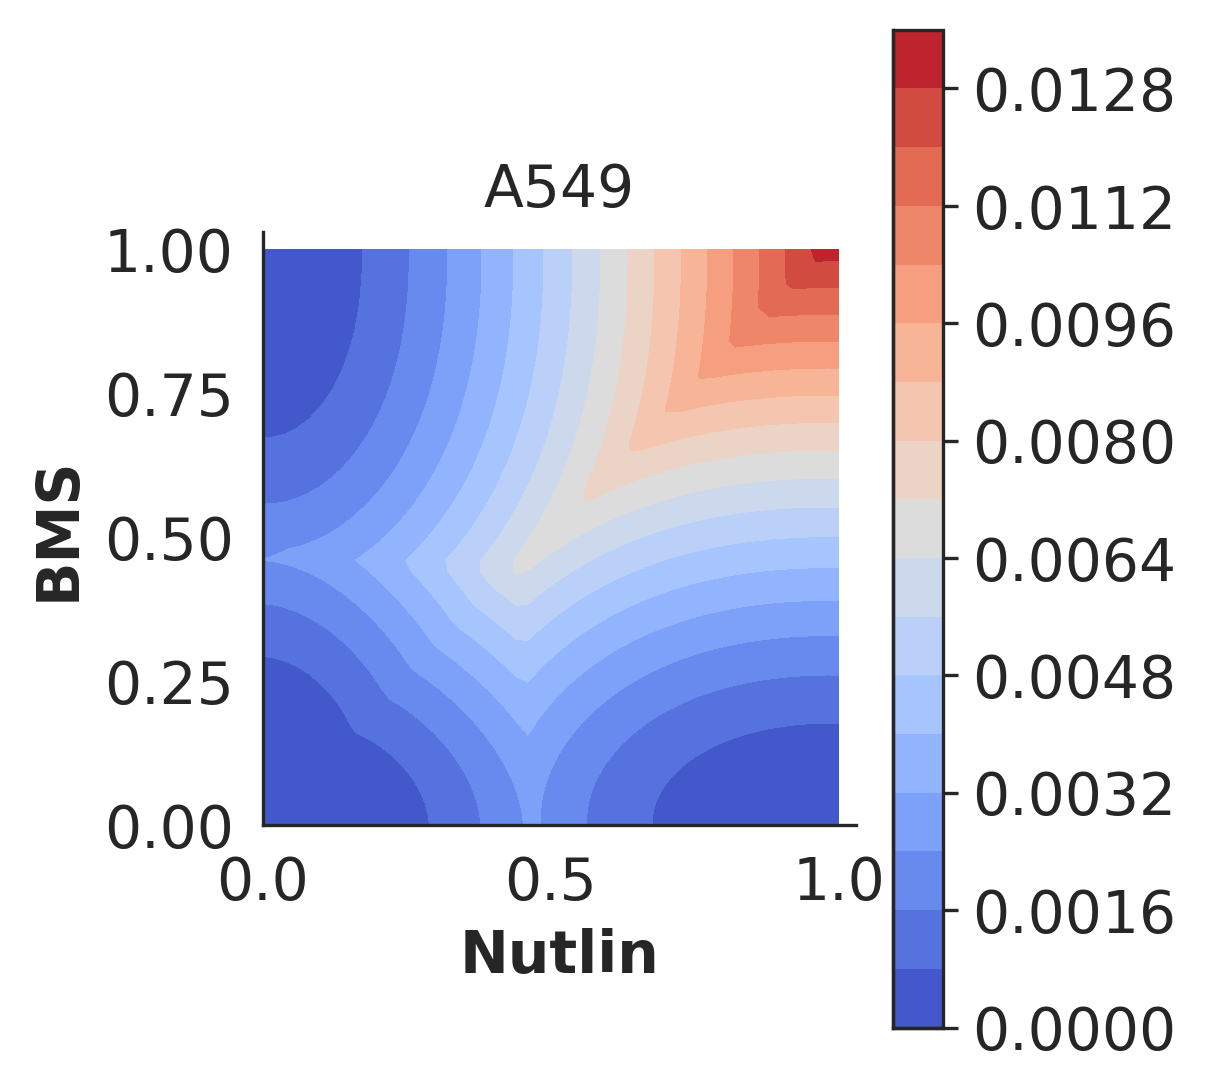

In [73]:
df_pred2D = cpa.pl.plot_uncertainty_comb_dose(
    compert_api=cpa_analyzer,
    cov='A549',
    pert='Nutlin+BMS',
    N=51,
    cond_key='treatment',
    metric='cosine',
)

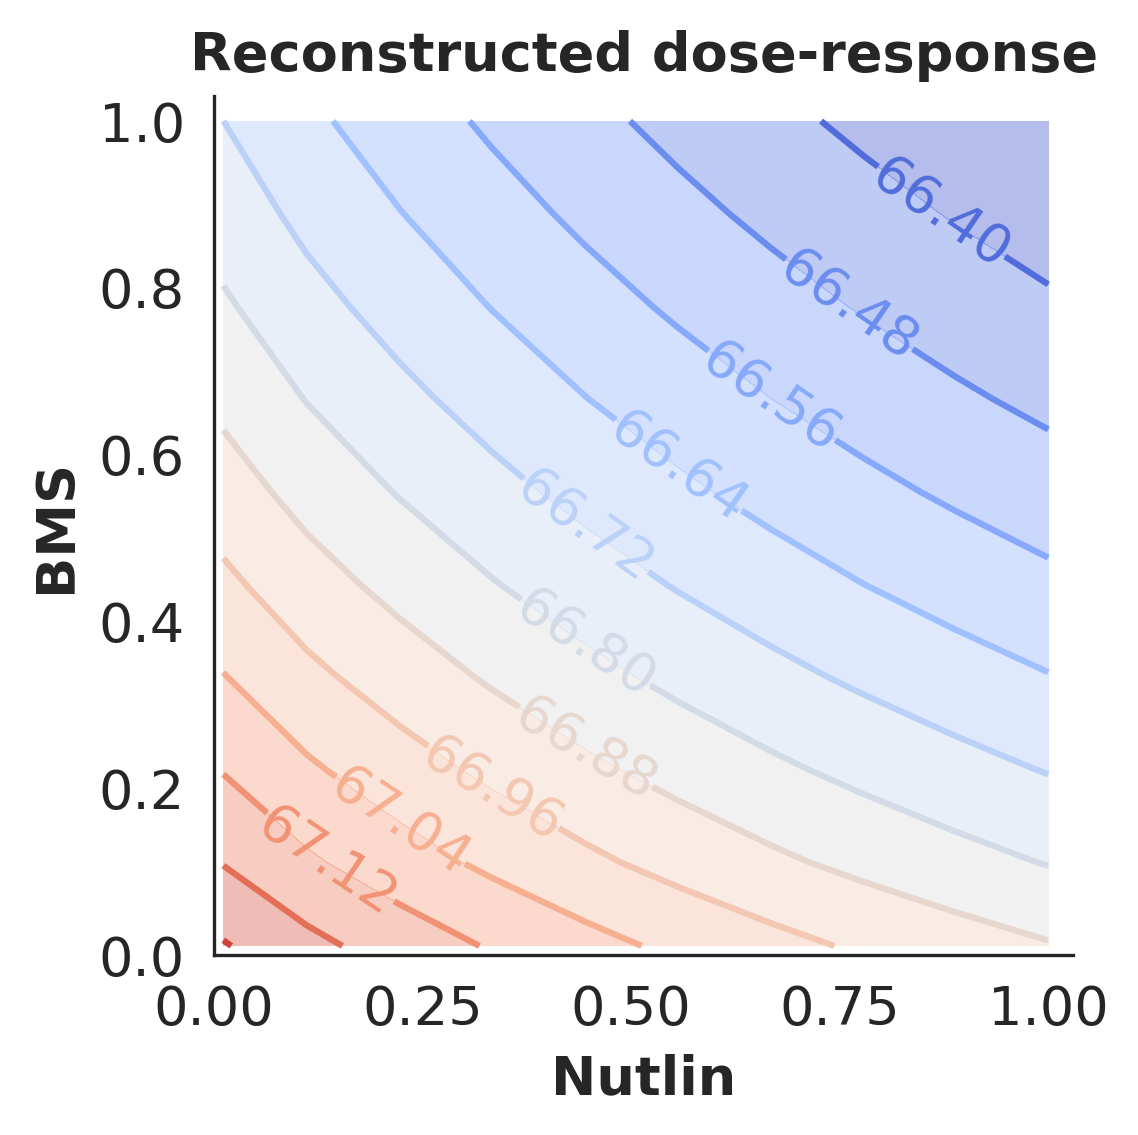

In [75]:
cpa_plots.plot_contvar_response2D(reconstructed_response2D, 
    title_name='Reconstructed dose-response', logdose=False)

### Prediction

In [55]:
adata

AnnData object with n_obs × n_vars = 14811 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', '_scvi_batch', '_scvi_labels', 'cell_type_scvi'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors', '_scvi'
    obsm: 'X_pca', 'X_umap', 'drugs_doses'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [57]:
print('Perturbations:', cpa_analyzer.unique_perts)
print('Covariates:', cpa_analyzer.unique_covars['cell_type'])
print('Datasets splits:', adata.obs['split'].unique())

Perturbations: ['SAHA', 'Vehicle', 'Dex', 'BMS', 'Nutlin']
Covariates: ['A549']
Datasets splits: ['test', 'ood', 'train']
Categories (3, object): ['ood', 'test', 'train']


In [59]:
genes_control = adata['test_control']

KeyError: 'test_control'